In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime, timedelta
import os
import joblib
import traceback
import warnings
import random # Still potentially useful for non-tuning randomness if needed

warnings.filterwarnings('ignore')

# Import ML Libraries
from sklearn.model_selection import train_test_split, TimeSeriesSplit # Keep TimeSeriesSplit if needed for other CV purposes
from sklearn.preprocessing import RobustScaler # Keep relevant preprocessors
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
# Removed RandomizedSearchCV and related imports (uniform, randint)
# Removed cvxpy as it wasn't used [cite: 1]

print("Libraries imported.")

Libraries imported.


In [78]:
# --- Global Configuration ---
# Basic configuration
np.random.seed(42) # To ensure consistent results
FILE_PATH = r"C:\Users\User\Downloads\final_merged_data_2.csv" 
MODEL_OUTPUT_DIR = 'bitcoin_onchain_models/'
PRICE_COLUMN = 'close' 
PERIODS_AHEAD = 1 # NOTE: 
TARGET_TYPE = 'Direction'
TARGET_COLUMN = 'target_direction' 
SCORING_METRIC = 'f1' 

# Data splitting parameters
TEST_SIZE = 0.20 
VALIDATION_SIZE = 0.15 


BACKTESTING_PARAMS = {
    'INITIAL_CASH': 10000,
    'COMMISSION_PERC': 0.0006, 
    'BASE_POSITION_SIZE': 0.1, 
}


In [79]:
# --- Default Model Parameters (using last known good/tuned values as fixed defaults) ---

# XGBoost parameters for Direction model (fixed defaults) [cite: 5]
XGB_CLS_DEFAULT_PARAMS = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'use_label_encoder': False,
    'n_estimators': 326,
    'learning_rate': 0.15592123566761282,
    'max_depth': 5,
    'subsample': 0.6478376983753207,
    'colsample_bytree': 0.7243929286862649,
    'gamma': 0.16259166101337352,
    'min_child_weight': 3,
    'random_state': 42,
    'n_jobs': -1,
    # Keep early stopping for fitting, but rounds won't be tuned
    'early_stopping_rounds': 10 # Or adjust as needed
}

# Random Forest parameters for Direction model (fixed defaults) [cite: 5, 6]
RF_CLS_DEFAULT_PARAMS = {
    'n_estimators': 234,
    'max_depth': 12,
    'min_samples_split': 9,
    'min_samples_leaf': 5,
    'max_features': 'sqrt',
    'class_weight': 'balanced',
    'random_state': 42,
    'n_jobs': -1
}

# MLP Classifier parameters (fixed defaults) [cite: 6]
MLP_CLS_DEFAULT_PARAMS = {
    'hidden_layer_sizes': (32,), 'activation': 'relu', 'solver': 'adam',
    'alpha': 0.0003058449429580245, 'batch_size': 'auto', 'learning_rate': 'adaptive',
    'learning_rate_init': 0.004109993861334124, 'max_iter': 300, 'shuffle': True,
    'random_state': 42, 'early_stopping': True, 'n_iter_no_change': 10,
    'validation_fraction': 0.1
}

# Logistic Regression parameters (fixed defaults) [cite: 6, 7]
LOGISTIC_DEFAULT_PARAMS = {
    'C': 0.5908361216819946, 'penalty': 'l2', 'solver': 'liblinear', 'random_state': 42,
    'max_iter': 1000, 'class_weight': 'balanced'
}

print("Default parameters for ML models defined.")

Default parameters for ML models defined.


In [80]:
# --- OnChain Strategy Class (Buy, Hold, Sell Mode) ---
class OnChainBitcoinStrategy:
    """Bitcoin trading strategy using on-chain metrics with buy, hold, and sell signals"""

    # --- Initialization ---
    def __init__(self, df, predictions, params=None, price_col='close'):
        """Initializes the strategy."""
        print("[DEBUG] OnChainBitcoinStrategy.__init__ called (Buy, Hold, Sell Mode).") # DEBUG
        try:
            self.df = df.copy()
            if self.df.empty:
                 print("[DEBUG] ERROR: Input DataFrame 'df' is empty in __init__.")
                 self.results = None
                 self.trade_history = pd.DataFrame(columns=['entry_date', 'exit_date', 'entry_price', 'exit_price', 'pnl_pct', 'result'])
                 return # Stop initialization

            # Ensure predictions align with df index before assigning
            if not isinstance(predictions, pd.Series):
                 if len(predictions) == len(self.df.index): predictions = pd.Series(predictions, index=self.df.index)
                 elif len(predictions) > 0: predictions = pd.Series(predictions, index=self.df.index[-len(predictions):])
                 else: predictions = pd.Series(0.5, index=self.df.index)

            if not self.df.index.equals(predictions.index):
                print("[DEBUG] Warning: DataFrame index and predictions index do not match. Reindexing predictions...")
                predictions = predictions.reindex(self.df.index, fill_value=0.5)

            self.df['prediction'] = predictions
            nan_pred_count = self.df['prediction'].isnull().sum()
            if nan_pred_count > 0:
                print(f"[DEBUG] Warning: Found {nan_pred_count} NaNs in prediction column after alignment. Filling with 0.5.")
                self.df['prediction'].fillna(0.5, inplace=True)

            self.params = params if params is not None else BACKTESTING_PARAMS.copy()
            self.price_col = price_col
            if self.price_col not in self.df.columns:
                print(f"[DEBUG] ERROR: Price column '{self.price_col}' not found in DataFrame columns: {self.df.columns.tolist()}")
                raise ValueError(f"Price column '{self.price_col}' not found in input DataFrame for strategy.")

            self.results = None
            self.trade_history = pd.DataFrame(columns=['entry_date', 'exit_date', 'entry_price', 'exit_price', 'pnl_pct', 'result'])

            print("[DEBUG] Initializing strategy simulation (_run_strategy - Buy, Hold, Sell)...") # DEBUG
            # --- Call _run_strategy ---
            run_strategy_output = self._run_strategy() # <<<< ERROR OCCURS HERE
            # --------------------------
            if isinstance(run_strategy_output, pd.DataFrame) and not run_strategy_output.empty:
                self.results = run_strategy_output
                print("[DEBUG] Strategy simulation finished, results DataFrame assigned.")
            else:
                print("[DEBUG] Warning: _run_strategy did not return a valid DataFrame.")
                self.results = None

        except AttributeError as ae: # Specific catch for the error
             print(f"[DEBUG] FATAL AttributeError during __init__: {ae}")
             print("[DEBUG] This likely means _run_strategy or another method was not correctly defined within the class scope.")
             traceback.print_exc()
             self.results = None
             self.trade_history = pd.DataFrame(columns=['entry_date', 'exit_date', 'entry_price', 'exit_price', 'pnl_pct', 'result'])
        except Exception as e:
            print(f"[DEBUG] ERROR during OnChainBitcoinStrategy initialization: {e}")
            traceback.print_exc()
            self.results = None
            self.trade_history = pd.DataFrame(columns=['entry_date', 'exit_date', 'entry_price', 'exit_price', 'pnl_pct', 'result'])

        # Add this method to your OnChainBitcoinStrategy class
    def _get_regime_adjustment(self, regime):
        """Get signal adjustment factor based on current market regime."""
        # Define simple adjustment factors for each regime
        regime_adjustments = {
            0: 0.8,    # Low flow, high transactions - slightly reduce signal
            1: 0.5,    # Low flow, low transactions - significantly reduce signal (conservative)
            2: 1.2,    # High flow, low transactions - amplify signal (more aggressive)
            3: 1.5,    # High flow, high transactions - strongly amplify signal (most aggressive)
            4: 0.7,    # Low flow, high transactions - moderately reduce signal
            5: 2.0     # Very high flow (extreme) - maximum amplification for rare opportunities
        }
        
        # Return default 1.0 (no adjustment) if regime not found
        return regime_adjustments.get(regime, 1.0)
    
    # --- Strategy Execution Logic (_run_strategy - Buy, Hold, Sell MODE) ---
    def _run_strategy(self):
        """Implements the trading strategy logic using ML prediction with buy, hold, and sell signals."""
        print("[DEBUG] _run_strategy (Buy, Hold, Sell Mode) starting...") # DEBUG
        results = self.df.copy()
        if 'prediction' not in results.columns:
                print("[DEBUG] ERROR: 'prediction' column missing in DataFrame for _run_strategy.")
                return None
        if self.price_col not in results.columns:
                print(f"[DEBUG] ERROR: Price column '{self.price_col}' missing in DataFrame for _run_strategy.")
                return None
    
        # Initialize portfolio metrics & state
        results['position'] = 0.0
        results['cash'] = self.params['INITIAL_CASH']
        results['btc_held'] = 0.0
        results['portfolio_value'] = self.params['INITIAL_CASH']
        results['trade'] = 0
        results['entry_price'] = np.nan
        results['trade_result'] = np.nan
        results['pnl'] = 0.0  # Add PnL column for tracking
        results['signal'] = 0  # Add signal column for tracking the ML signal (buy/hold/sell)
        local_trade_history = []
        entry_dates = []
        exit_dates = []
    
        print(f"[DEBUG] Starting buy, hold, sell backtest loop for {len(results)} steps...")
    
        # --- Main Backtest Loop (Buy, Hold, Sell Mode) ---
        for i in range(1, len(results)):
            current_date = results.index[i]
            try: # Main data access block
                current_price = results.iloc[i][self.price_col]
                prediction = results.iloc[i]['prediction']
                
                # --- Generate signal based on prediction thresholds ---
                # We'll use thresholds to determine the signal:
                # Buy: prediction > 0.6 (strongly bullish)
                # Hold: 0.4 <= prediction <= 0.6 (neutral/uncertain)
                # Sell: prediction < 0.4 (strongly bearish)
                
                current_regime = -1
                if 'current_regime' in results.columns:
                    current_regime = results.iloc[i]['current_regime']
                    
                # Get adjustment factor based on regime
                regime_adjustment = self._get_regime_adjustment(current_regime)
                
                # Apply regime adjustment to prediction thresholds
                if prediction > (0.55 - (0.05 * (regime_adjustment - 1.0))):
                    ml_signal = 1  # Buy Signal (threshold lowered for aggressive regimes)
                elif prediction < (0.45 + (0.05 * (regime_adjustment - 1.0))):
                    ml_signal = -1  # Sell Signal (threshold raised for aggressive regimes)
                else:
                    ml_signal = 0  # Hold Signal (neutral zone)
                
                # Store the signal and regime in the results DataFrame
                results.iloc[i, results.columns.get_loc('signal')] = ml_signal
                if current_regime != -1:
                    # Create current_regime column if it doesn't exist
                    if 'used_regime' not in results.columns:
                        results['used_regime'] = -1
                    results.iloc[i, results.columns.get_loc('used_regime')] = current_regime
    
                if pd.isna(current_price) or pd.isna(prediction): # Skip step if data missing
                        results.iloc[i, results.columns.get_loc('portfolio_value')] = results.iloc[i-1]['portfolio_value'] # Carry forward
                        results.iloc[i, results.columns.get_loc('position')] = results.iloc[i-1]['position']
                        results.iloc[i, results.columns.get_loc('cash')] = results.iloc[i-1]['cash']
                        results.iloc[i, results.columns.get_loc('btc_held')] = results.iloc[i-1]['btc_held']
                        results.iloc[i, results.columns.get_loc('entry_price')] = results.iloc[i-1]['entry_price']
                        results.iloc[i, results.columns.get_loc('trade_result')] = results.iloc[i-1]['trade_result']
                        results.iloc[i, results.columns.get_loc('pnl')] = results.iloc[i-1]['pnl']
                        results.iloc[i, results.columns.get_loc('signal')] = results.iloc[i-1]['signal']
                        continue
            except (KeyError, IndexError) as e:
                    print(f"[DEBUG] ERROR accessing data at index {i} (Date: {current_date}): {e}. Stopping simulation.")
                    traceback.print_exc()
                    return None
    
            # Get previous state
            prev_position = results.iloc[i-1]['position']
            prev_cash = results.iloc[i-1]['cash']
            prev_btc_held = results.iloc[i-1]['btc_held']
            prev_entry_price = results.iloc[i-1]['entry_price']
    
            # Initialize current step
            results.iloc[i, results.columns.get_loc('cash')] = prev_cash
            results.iloc[i, results.columns.get_loc('btc_held')] = prev_btc_held
            results.iloc[i, results.columns.get_loc('position')] = prev_position
            results.iloc[i, results.columns.get_loc('entry_price')] = prev_entry_price
            results.iloc[i, results.columns.get_loc('trade')] = 0
            results.iloc[i, results.columns.get_loc('trade_result')] = np.nan
            results.iloc[i, results.columns.get_loc('pnl')] = 0.0
    
            # --- Buy, Hold, Sell Strategy Logic ---
            trade_executed_this_step = False
            transaction_fee = 0.0
    
            # --- Buy Logic (Strong Bullish Signal) ---
            if ml_signal == 1: # If ML predicts strong rise, we buy
                # Adjust position size based on regime
                base_position_size = self.params['BASE_POSITION_SIZE']

                # Apply regime adjustment to position sizing
                if current_regime != -1:
                    regime_factor = self._get_regime_adjustment(current_regime)
                    position_size_factor = base_position_size * regime_factor
                else:
                    position_size_factor = base_position_size

                # Cap position size at 50% for safety
                position_size_factor = min(position_size_factor, 0.5)

                trade_amount = min(prev_cash * position_size_factor, prev_cash)
    
                if trade_amount > 10 and current_price > 0: # Minimum trade amount check
                    fee = trade_amount * self.params['COMMISSION_PERC']
                    transaction_fee += fee
                    
                    btc_to_buy = trade_amount / current_price * (1 - self.params['COMMISSION_PERC'])
                    results.iloc[i, results.columns.get_loc('cash')] = prev_cash - trade_amount
                    results.iloc[i, results.columns.get_loc('btc_held')] += btc_to_buy # Add to holdings
                    results.iloc[i, results.columns.get_loc('position')] = 1
                    results.iloc[i, results.columns.get_loc('trade')] = 1
                    
                    # Calculate average entry price
                    if pd.isna(prev_entry_price) or prev_btc_held == 0:
                        results.iloc[i, results.columns.get_loc('entry_price')] = current_price
                    else:
                        # Calculate weighted average price when adding to position
                        total_btc = prev_btc_held + btc_to_buy
                        if total_btc > 0:  # Avoid division by zero
                            avg_price = ((prev_btc_held * prev_entry_price) + (btc_to_buy * current_price)) / total_btc
                            results.iloc[i, results.columns.get_loc('entry_price')] = avg_price
                    
                    entry_dates.append(current_date)
                    trade_executed_this_step = True
                    print(f"[DEBUG] Buy executed at {current_date} - Price: {current_price:.2f}, Pred: {prediction:.3f}, BTC Held: {results.iloc[i]['btc_held']:.6f}")
    
            # --- Hold Logic (Neutral Signal) ---
            elif ml_signal == 0:
                # Simply maintain the current position
                # No changes to cash, btc_held, or portfolio values needed
                print(f"[DEBUG] Hold position at {current_date} - Price: {current_price:.2f}, Pred: {prediction:.3f}, BTC Held: {prev_btc_held:.6f}")
    
            # --- Sell Logic (Strong Bearish Signal) ---
            # --- Sell Logic (Strong Bearish Signal) ---
            elif ml_signal == -1 and prev_btc_held > 0: # If ML predicts strong drop and we hold BTC
                # In sell mode, we sell a portion of holdings (not necessarily all)
                # Adjust sell portion based on regime
                base_sell_portion = 0.5  # Default sell 50% of current holdings
                
                # Apply regime adjustment to sell portion
                if current_regime != -1:
                    regime_factor = self._get_regime_adjustment(current_regime)
                    # Inverse relationship - sell more in conservative regimes, less in aggressive
                    sell_portion = base_sell_portion * (2.0 - min(regime_factor, 1.5))
                else:
                    sell_portion = base_sell_portion
                    
                # Cap sell portion between 0.2 and 0.9 for safety
                sell_portion = max(0.2, min(sell_portion, 0.9))
                
                btc_to_sell = prev_btc_held * sell_portion
                
                if btc_to_sell > 0 and current_price > 0: # Process Sell
                    fee = btc_to_sell * current_price * self.params['COMMISSION_PERC']
                    transaction_fee += fee
                    
                    cash_return = btc_to_sell * current_price * (1 - self.params['COMMISSION_PERC'])
                    results.iloc[i, results.columns.get_loc('cash')] = prev_cash + cash_return
                    results.iloc[i, results.columns.get_loc('btc_held')] = prev_btc_held - btc_to_sell
                    
                    # If we still hold some BTC, maintain position as 1, otherwise 0
                    remaining_btc = prev_btc_held - btc_to_sell
                    results.iloc[i, results.columns.get_loc('position')] = 1 if remaining_btc > 0 else 0
                    
                    results.iloc[i, results.columns.get_loc('trade')] = -1
                    
                    # Only reset entry price if all BTC sold
                    if remaining_btc <= 0:
                        results.iloc[i, results.columns.get_loc('entry_price')] = np.nan
                    
                    trade_executed_this_step = True
                    exit_dates.append(current_date)
                    
                    # Calculate trade result for history
                    if not pd.isna(prev_entry_price) and prev_entry_price > 0:
                        pnl_pct = ((current_price / prev_entry_price) - 1) * 100
                        result_type = 'Win (Sell)' if current_price > prev_entry_price else 'Loss (Sell)'
                        results.iloc[i, results.columns.get_loc('trade_result')] = 1 if current_price > prev_entry_price else -1
                        
                        # Record the trade with partial sell information
                        local_trade_history.append({
                            'entry_date': entry_dates[-1] if entry_dates else None,
                            'exit_date': current_date,
                            'entry_price': prev_entry_price,
                            'exit_price': current_price,
                            'pnl_pct': pnl_pct,
                            'result': result_type,
                            'btc_sold': btc_to_sell,
                            'btc_remaining': remaining_btc
                        })
                    else:
                        results.iloc[i, results.columns.get_loc('trade_result')] = 0
                    
                    print(f"[DEBUG] Partial Sell executed at {current_date} - Price: {current_price:.2f}, Pred: {prediction:.3f}, Sold: {btc_to_sell:.6f} BTC, Remaining: {remaining_btc:.6f} BTC")
    
            # --- Calculate Price Change based PnL ---
            # PnL = price change * position - trade amount * transaction fees
            # Find this section in the _run_strategy method of the OnChainBitcoinStrategy class
            # Replace the PnL calculation section with this code:
            
            # --- Calculate Price Change based PnL using the simplified formula ---
            if i > 1:  # Need at least two points for price change
                price_change = (current_price / results.iloc[i-1][self.price_col]) - 1
                
                # Get previous position indicator (1 for long, 0 for none, -1 for short)
                prev_position_indicator = prev_position  # Using the existing position value (1 for long, 0 for none)
                
                # Get current position indicator
                current_position_indicator = results.iloc[i]['position']
                
                # Calculate position change for fee calculation
                position_change = abs(current_position_indicator - prev_position_indicator)
                
                # Calculate commission fee based on position change
                if position_change > 0:
                    position_change_fee = position_change * self.params['COMMISSION_PERC'] * current_price * prev_btc_held
                else:
                    position_change_fee = 0
                
                # Calculate PnL using your formula
                # pnl = (price_change * prev_position_indicator) - (position_change * commission_fees)
                results.iloc[i, results.columns.get_loc('pnl')] = (price_change * prev_position_indicator) - position_change_fee
            else:
                results.iloc[i, results.columns.get_loc('pnl')] = 0.0
            
            # --- Update Portfolio Value ---
            try: # Wrap update in try-except
                current_btc_held = results.iloc[i]['btc_held']
                current_cash = results.iloc[i]['cash']
                if pd.notna(current_price) and current_price > 0:
                    btc_value = current_btc_held * current_price
                    results.iloc[i, results.columns.get_loc('portfolio_value')] = current_cash + btc_value
                elif pd.notna(results.iloc[i-1]['portfolio_value']):
                    results.iloc[i, results.columns.get_loc('portfolio_value')] = results.iloc[i-1]['portfolio_value']
                else:
                    results.iloc[i, results.columns.get_loc('portfolio_value')] = current_cash
    
            except Exception as e_update:
                print(f"[DEBUG] ERROR updating portfolio value at step {i}: {e_update}")
                traceback.print_exc()
                return None
        # --- End of Loop ---
        print("[DEBUG] Buy, hold, sell backtest loop finished.")
    
        # --- Post-Loop Calculations ---
        try:
            results['daily_return'] = results['portfolio_value'].pct_change().fillna(0)
            initial_cash = self.params.get('INITIAL_CASH', 1)
            initial_cash = 1 if initial_cash <= 0 else initial_cash
            results['cumulative_return'] = (results['portfolio_value'] / initial_cash) - 1
            
            # Save trade history
            self.trade_history = pd.DataFrame(local_trade_history) if local_trade_history else pd.DataFrame(
                columns=['entry_date', 'exit_date', 'entry_price', 'exit_price', 'pnl_pct', 'result', 'btc_sold', 'btc_remaining'])
                
        except Exception as e_post:
            print(f"[DEBUG] ERROR during post-loop calculations: {e_post}")
            traceback.print_exc()
            return results # Return partial results
    
        print(f"[DEBUG] Finished _run_strategy (Buy, Hold, Sell). Returning results DataFrame. Trades: {len(self.trade_history)}")
        return results
    
    # --- Metrics Calculation ---
    def calculate_metrics(self):
        """Calculate performance metrics using custom PnL and Sharpe ratio calculations"""
        if not hasattr(self, 'results') or self.results is None or 'portfolio_value' not in self.results.columns:
            print("Warning: results attribute missing or invalid for metrics calculation.")
            return {metric: 0 for metric in ['total_return', 'annual_return', 'sharpe', 'max_drawdown', 'win_rate', 'total_trades', 'profit_factor', 'sqn']}
        
        # Extract necessary data
        results = self.results
        epsilon = 1e-9
        initial_cash = self.params.get('INITIAL_CASH', 1)
        initial_cash = epsilon if initial_cash <= 0 else initial_cash
        final_value = results['portfolio_value'].iloc[-1] if not results.empty else initial_cash
        
        # Basic returns calculation
        total_return = (final_value / initial_cash) - 1
        
        # Use PnL values directly from results
        try:
            # Get PnL values
            pnl_values = results['pnl'].dropna()
            
            # Custom Sharpe ratio calculation
            # sharpe_ratio = average(pnl)/standard_deviation(pnl) * sqrt(365*24)
            if len(pnl_values) > 1:
                pnl_mean = pnl_values.mean()
                pnl_std = pnl_values.std()
                
                if pnl_std > epsilon:
                    # Using hourly factor as specified: √(365*24)
                    hourly_factor = np.sqrt(365 * 24)
                    sharpe_ratio = pnl_mean / pnl_std * hourly_factor
                else:
                    sharpe_ratio = 0
            else:
                sharpe_ratio = 0
            
            # Calculate max drawdown from portfolio value
            portfolio_value = results['portfolio_value']
            rolling_max = portfolio_value.cummax()
            safe_rolling_max = rolling_max.replace(0, np.nan).fillna(method='ffill').fillna(epsilon)
            drawdown = (portfolio_value - rolling_max) / safe_rolling_max
            max_drawdown = drawdown.min() if drawdown.notna().any() else 0
            
            # Count total trades (buys and sells)
            buy_trades = (results['trade'] == 1).sum()
            sell_trades = (results['trade'] == -1).sum()
            total_trades = buy_trades + sell_trades
            
            # Calculate win rate based on positive PnLs
            positive_pnls = (pnl_values > 0).sum()
            win_rate = positive_pnls / len(pnl_values) if len(pnl_values) > 0 else 0
            
            # Calculate profit factor (sum of positive PnLs / abs(sum of negative PnLs))
            positive_pnl_sum = pnl_values[pnl_values > 0].sum()
            negative_pnl_sum = abs(pnl_values[pnl_values < 0].sum())
            profit_factor = positive_pnl_sum / negative_pnl_sum if negative_pnl_sum > epsilon else float('inf') if positive_pnl_sum > 0 else 0
            
            # Calculate SQN (System Quality Number)
            sqn = np.sqrt(len(pnl_values)) * pnl_values.mean() / pnl_values.std() if len(pnl_values) > 1 and pnl_values.std() > epsilon else 0
            
        except Exception as e:
            print(f"[DEBUG] Error calculating custom metrics: {e}")
            traceback.print_exc()
            # Return default values if calculation fails
            return {
                'total_return': total_return, 
                'annual_return': 0, 
                'sharpe': 0, 
                'max_drawdown': 0, 
                'win_rate': 0, 
                'total_trades': 0, 
                'profit_factor': 0, 
                'sqn': 0
            }
        
        # Return calculated metrics
        return {
            'total_return': total_return,
            'annual_return': total_return / (len(results) / (365 * 24)) if len(results) > 0 else 0,  # Annualized based on hourly data
            'sharpe': sharpe_ratio if np.isfinite(sharpe_ratio) else 0,
            'max_drawdown': max_drawdown if np.isfinite(max_drawdown) else 0,
            'win_rate': win_rate,
            'total_trades': total_trades,
            'profit_factor': profit_factor if np.isfinite(profit_factor) else 0,
            'sqn': sqn if np.isfinite(sqn) else 0
        }

    # --- Plotting Results ---
    def plot_results(self):
        """Plot backtest results: Portfolio Value vs Price and Cumulative Returns."""
        if not hasattr(self, 'results') or self.results is None or self.results.empty: 
            print("Cannot plot results: Results DataFrame is not available or empty.")
            return
        if self.price_col not in self.results.columns: 
            print(f"Cannot plot results: Price column '{self.price_col}' not found.")
            return
            
        results = self.results
        plt.style.use('seaborn-v0_8-darkgrid')
        fig, axes = plt.subplots(3, 1, figsize=(14, 15), sharex=True)
        fig.suptitle('Buy, Hold, Sell Bitcoin Trading Backtest Results', fontsize=16)
        
        # Portfolio Value & Price Plot
        ax1 = axes[0]
        ax1.plot(results.index, results['portfolio_value'], label='Portfolio Value', color='blue', linewidth=1.5)
        ax1.set_ylabel('Portfolio Value ($)', color='blue', fontsize=12)
        ax1.tick_params(axis='y', labelcolor='blue')
        ax1.set_title('Portfolio Value & Trades vs Price', fontsize=14)
        
        ax1b = ax1.twinx()
        ax1b.plot(results.index, results[self.price_col], label=f'{self.price_col.capitalize()} Price', 
                 color='orange', alpha=0.6, linewidth=1.5)
        ax1b.set_ylabel(f'{self.price_col.capitalize()} Price ($)', color='orange', fontsize=12)
        ax1b.tick_params(axis='y', labelcolor='orange')

        if 'current_regime' in self.results.columns:
            regime_colors = {
                0: 'lightblue',   # Low flow, high transactions
                1: 'lightgray',   # Low flow, low transactions 
                2: 'lightgreen',  # High flow, low transactions
                3: 'lightcoral',  # High flow, high transactions
                4: 'lightyellow', # Low flow, high transactions
                5: 'pink'         # Very high flow (extreme)
            }
            
            # Get unique dates where regime changes
            regime_changes = self.results.reset_index()
            regime_changes = regime_changes[['datetime', 'current_regime']].drop_duplicates()
            regime_changes = regime_changes.sort_values('datetime')
            
            # Plot regime background colors
            for i in range(len(regime_changes) - 1):
                start_date = regime_changes.iloc[i]['datetime']
                end_date = regime_changes.iloc[i+1]['datetime']
                regime = regime_changes.iloc[i]['current_regime']
                ax1.axvspan(start_date, end_date, alpha=0.2, color=regime_colors.get(regime, 'white'))
            
            # Add legend for regimes
            from matplotlib.patches import Patch
            regime_legend_elements = [
                Patch(facecolor=color, alpha=0.2, label=f'Regime {r}')
                for r, color in regime_colors.items()
            ]
            ax1.legend(handles=regime_legend_elements + ax1.legend().get_patches(), 
                       loc='upper left')
        
        # Plot buy and sell signals
        buy_signals = results[results['trade'] == 1]
        sell_signals = results[results['trade'] == -1]
        hold_signals = results[results['signal'] == 0]  # Get the hold signals for visualization
        
        if not buy_signals.empty:
            ax1.scatter(buy_signals.index, buy_signals['portfolio_value'], marker='^', 
                       color='lime', s=70, label='Buy', alpha=0.9, edgecolors='k', linewidth=0.5, zorder=5)
        
        if not sell_signals.empty:
            ax1.scatter(sell_signals.index, sell_signals['portfolio_value'], marker='v', 
                       color='red', s=70, label='Sell', alpha=0.9, edgecolors='k', linewidth=0.5, zorder=5)
        
        # We could also mark hold signals, but they might clutter the chart
        # Let's just highlight a few significant hold signals 
        if not hold_signals.empty:
            # Sample only a few hold signals to avoid cluttering
            sample_size = min(20, len(hold_signals))
            sampled_holds = hold_signals.sample(sample_size) if len(hold_signals) > sample_size else hold_signals
            
            ax1.scatter(sampled_holds.index, sampled_holds['portfolio_value'], marker='o', 
                       color='yellow', s=50, label='Hold (sample)', alpha=0.7, edgecolors='k', linewidth=0.5, zorder=4)
        
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax1b.get_legend_handles_labels()
        ax1.legend(lines + lines2, labels + labels2, loc='upper left')
        ax1.grid(True, alpha=0.5)
        
        # Cumulative Return Plot
        ax2 = axes[1]
        ax2.plot(results.index, results['cumulative_return'] * 100, 
                label='Strategy Cumulative Return', color='green', linewidth=2)
        
        start_price = results[self.price_col].iloc[0] if not results.empty and results[self.price_col].iloc[0] != 0 else 1
        btc_buy_hold_return = (results[self.price_col] / start_price) - 1
        ax2.plot(results.index, btc_buy_hold_return * 100, 
                label='Buy & Hold Cumulative Return', color='gray', linestyle='--')
        
        ax2.set_ylabel('Cumulative Return (%)', fontsize=12)
        ax2.set_title('Strategy vs Buy & Hold Returns', fontsize=14)
        ax2.legend(loc='upper left')
        ax2.grid(True, alpha=0.5)
        
        # Signal & PnL Plot
        ax3 = axes[2]
        # Plot colored bands for signal type
        for i in range(1, len(results)):
            if results['signal'].iloc[i] == 1:  # Buy signal
                ax3.axvspan(results.index[i-1], results.index[i], alpha=0.2, color='green')
            elif results['signal'].iloc[i] == -1:  # Sell signal
                ax3.axvspan(results.index[i-1], results.index[i], alpha=0.2, color='red')
            elif results['signal'].iloc[i] == 0:  # Hold signal
                ax3.axvspan(results.index[i-1], results.index[i], alpha=0.2, color='yellow')
        
        # Plot PnL line on top of the colored bands
        ax3.plot(results.index, results['pnl'], label='Daily PnL', color='blue', linewidth=1, zorder=5)
        ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.7)
        
        ax3.set_ylabel('PnL / Signal', fontsize=12)
        ax3.set_title('Daily PnL with Signal Type', fontsize=14)
        
        # Create custom legend for signal bands
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='green', alpha=0.2, label='Buy Signal'),
            Patch(facecolor='yellow', alpha=0.2, label='Hold Signal'),
            Patch(facecolor='red', alpha=0.2, label='Sell Signal'),
            plt.Line2D([0], [0], color='blue', lw=2, label='Daily PnL')
        ]
        ax3.legend(handles=legend_elements, loc='upper left')
        ax3.grid(True, alpha=0.5)
        
        # Format x-axis
        ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.xticks(rotation=45)
        plt.tight_layout(rect=[0, 0.03, 1, 0.97])
        
        img_path = os.path.join(MODEL_OUTPUT_DIR, 'buy_hold_sell_results.png')
        os.makedirs(os.path.dirname(img_path) or '.', exist_ok=True)
        
        try:
            plt.savefig(img_path)
            print(f"Buy, hold, sell backtest results plot saved to {img_path}")
        except Exception as e_save:
            print(f"Error saving plot: {e_save}")
            
        plt.show()
        
        # Plot signal distribution as a separate chart
        self._plot_signal_distribution()
        
        # Plot trade analysis if we have trade history
        if hasattr(self, 'trade_history') and self.trade_history is not None and not self.trade_history.empty:
            self._plot_trade_analysis()
        else:
            print("No trade history found, skipping trade analysis plot.")
    
    # --- Plotting Signal Distribution ---
def _plot_signal_distribution(self):
    """Plot signal distribution and statistics."""
    if not hasattr(self, 'results') or self.results is None or 'signal' not in self.results.columns:
        print("Cannot plot signal distribution: Results missing or invalid.")
        return
        
    results = self.results
    
    # Count occurrences of each signal type
    signal_counts = results['signal'].value_counts().reindex([1, 0, -1], fill_value=0)
    labels = ['Buy (1)', 'Hold (0)', 'Sell (-1)']
    colors = ['green', 'yellow', 'red']
    
    plt.figure(figsize=(14, 10))
    
    # Create two subplots
    plt.subplot(2, 2, 1)
    plt.pie(signal_counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, shadow=True)
    plt.title('Signal Distribution', fontsize=14)
    
    # Bar chart of signal counts
    plt.subplot(2, 2, 2)
    bars = plt.bar(labels, signal_counts, color=colors, alpha=0.7)
    plt.title('Signal Counts', fontsize=14)
    plt.ylabel('Count', fontsize=12)
    
    # Add count values on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                 f'{int(height)}', ha='center', va='bottom')
    
    # PnL by Signal Type
    plt.subplot(2, 2, 3)
    
    # Group by signal type and calculate mean PnL
    signal_pnl = results.groupby('signal')['pnl'].agg(['mean', 'sum', 'count'])
    if not signal_pnl.empty:
        signal_labels = ['Buy Signal', 'Hold Signal', 'Sell Signal']
        signal_types = [1, 0, -1]
        means = [signal_pnl.loc[t, 'mean'] if t in signal_pnl.index else 0 for t in signal_types]
        
        bars = plt.bar(signal_labels, means, color=colors, alpha=0.7)
        plt.title('Average PnL by Signal Type', fontsize=14)
        plt.ylabel('Average PnL', fontsize=12)
        
        # Add values on top of bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., 
                     height + 0.02 if height >= 0 else height - 0.05,
                     f'{height:.2f}', ha='center', va='bottom' if height >= 0 else 'top')
    
    # Signal transitions
    plt.subplot(2, 2, 4)
    
    # Create a signal transition matrix
    transitions = pd.crosstab(results['signal'].shift(1), results['signal'], 
                            rownames=['From'], colnames=['To'])
    
    # Convert to percentages row-wise
    transitions_pct = transitions.div(transitions.sum(axis=1), axis=0) * 100
    
    # Create heatmap of transitions
    sns.heatmap(transitions_pct.reindex([1, 0, -1], axis=0).reindex([1, 0, -1], axis=1), 
               annot=True, cmap='YlGnBu', fmt='.1f', 
               xticklabels=['Buy', 'Hold', 'Sell'],
               yticklabels=['Buy', 'Hold', 'Sell'])
    plt.title('Signal Transition Matrix (%)', fontsize=14)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle('Signal Analysis', fontsize=16)
    
    img_path = os.path.join(MODEL_OUTPUT_DIR, 'signal_distribution.png')
    os.makedirs(os.path.dirname(img_path) or '.', exist_ok=True)
    
    try:
        plt.savefig(img_path)
        print(f"Signal distribution plot saved to {img_path}")
    except Exception as e_save:
        print(f"Error saving signal distribution plot: {e_save}")
        
    plt.show()
    
    # Also plot the signal over time
    plt.figure(figsize=(14, 6))
    plt.title('Signal Over Time', fontsize=16)
    
    # Create colored background based on prediction values
    plt.pcolormesh(
        [mdates.date2num(d) for d in results.index], 
        [0, 1], 
        np.array([results['prediction'].values, results['prediction'].values]),
        cmap='RdYlGn', alpha=0.3, vmin=0, vmax=1
    )
    
    # Plot the discretized signal
    plt.plot(results.index, results['signal'], color='black', linewidth=1.5, label='Signal')
    
    # Add horizontal lines to mark signal levels
    plt.axhline(y=1, color='green', linestyle='--', alpha=0.7, label='Buy Threshold')
    plt.axhline(y=0, color='yellow', linestyle='--', alpha=0.7, label='Hold Zone')
    plt.axhline(y=-1, color='red', linestyle='--', alpha=0.7, label='Sell Threshold')
    
    plt.ylabel('Signal Value', fontsize=12)
    plt.xlabel('Date', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.5)
    
    # Set y-axis limits with some padding
    plt.ylim(-1.5, 1.5)
    
    # Set y-ticks to show only -1, 0, 1
    plt.yticks([-1, 0, 1], ['Sell (-1)', 'Hold (0)', 'Buy (1)'])
    
    plt.gcf().autofmt_xdate()  # Rotate date labels
    
    img_path = os.path.join(MODEL_OUTPUT_DIR, 'signal_over_time.png')
    try:
        plt.savefig(img_path)
        print(f"Signal over time plot saved to {img_path}")
    except Exception as e_save:
        print(f"Error saving signal over time plot: {e_save}")
        
    plt.show()

# --- Plotting Trade Analysis ---
def _plot_trade_analysis(self):
    """Plot detailed trade analysis: Individual PnL and Cumulative PnL."""
    if self.trade_history.empty:
        print("No trade history to plot.")
        return
        
    if 'pnl_pct' not in self.trade_history.columns:
        print("Trade history missing 'pnl_pct' column.")
        return
        
    trades_df = self.trade_history.copy()
    trades_df['pnl_pct'] = pd.to_numeric(trades_df['pnl_pct'], errors='coerce')
    trades_df.dropna(subset=['pnl_pct'], inplace=True)
    
    if trades_df.empty:
        print("No valid trades with PnL percentage to plot.")
        return
        
    plt.style.use('seaborn-v0_8-darkgrid')
    fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
    fig.suptitle('Trade Analysis (Buy, Hold, Sell Strategy)', fontsize=16)
    
    trade_indices = range(len(trades_df))
    
    # Individual trade PnL
    ax1 = axes[0]
    colors = ['green' if x > 0 else 'red' for x in trades_df['pnl_pct']]
    ax1.bar(trade_indices, trades_df['pnl_pct'], color=colors)
    ax1.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.7)
    ax1.set_title('Individual Trade Profit/Loss (%)', fontsize=14)
    ax1.set_ylabel('PnL (%)', fontsize=12)
    ax1.grid(True, axis='y', linestyle='--', alpha=0.5)
    
    # Cumulative PnL
    ax2 = axes[1]
    cumulative_pnl = trades_df['pnl_pct'].cumsum()
    ax2.plot(trade_indices, cumulative_pnl, marker='.', markersize=5, 
            linestyle='-', color='blue', label='Cumulative PnL')
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.7)
    
    ax2.fill_between(trade_indices, 0, cumulative_pnl, where=(cumulative_pnl >= 0), 
                    color='green', alpha=0.3, interpolate=True)
    ax2.fill_between(trade_indices, 0, cumulative_pnl, where=(cumulative_pnl < 0), 
                    color='red', alpha=0.3, interpolate=True)
    
    ax2.set_title('Cumulative Trade P&L (%)', fontsize=14)
    ax2.set_xlabel('Trade Number', fontsize=12)
    ax2.set_ylabel('Cumulative PnL (%)', fontsize=12)
    ax2.grid(True, axis='y', linestyle='--', alpha=0.5)
    ax2.legend()
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    
    img_path = os.path.join(MODEL_OUTPUT_DIR, 'buy_hold_sell_trade_analysis.png')
    os.makedirs(os.path.dirname(img_path) or '.', exist_ok=True)
    
    try:
        plt.savefig(img_path)
        print(f"Trade analysis plot saved to {img_path}")
    except Exception as e_save:
        print(f"Error saving trade analysis plot: {e_save}")
        
    plt.show()
    
    # Additional trade metrics visualization
    if 'btc_sold' in trades_df.columns and 'btc_remaining' in trades_df.columns:
        plt.figure(figsize=(14, 8))
        plt.title('BTC Position Management', fontsize=16)
        
        # Create a stacked bar chart of sold vs remaining BTC
        sold = trades_df['btc_sold']
        remaining = trades_df['btc_remaining']
        
        plt.bar(trade_indices, sold, label='BTC Sold', color='red', alpha=0.7)
        plt.bar(trade_indices, remaining, bottom=sold, label='BTC Remaining', color='blue', alpha=0.7)
        
        plt.xlabel('Trade Number', fontsize=12)
        plt.ylabel('BTC Amount', fontsize=12)
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.5)
        
        img_path = os.path.join(MODEL_OUTPUT_DIR, 'buy_hold_sell_btc_position.png')
        try:
            plt.savefig(img_path)
            print(f"BTC position management plot saved to {img_path}")
        except Exception as e_save:
            print(f"Error saving BTC position plot: {e_save}")
            
        plt.show()
        
        # Plot of BTC holdings over time
        if not self.results.empty and 'btc_held' in self.results.columns:
            plt.figure(figsize=(14, 6))
            plt.title('BTC Holdings Over Time', fontsize=16)
            
            plt.plot(self.results.index, self.results['btc_held'], color='orange', linewidth=2)
            
            # Mark buy points
            buy_signals = self.results[self.results['trade'] == 1]
            if not buy_signals.empty:
                plt.scatter(buy_signals.index, buy_signals['btc_held'], 
                           marker='^', color='green', s=70, label='Buy', 
                           alpha=0.9, edgecolors='k', linewidth=0.5)
            
            # Mark sell points
            sell_signals = self.results[self.results['trade'] == -1]
            if not sell_signals.empty:
                plt.scatter(sell_signals.index, sell_signals['btc_held'], 
                           marker='v', color='red', s=70, label='Sell', 
                           alpha=0.9, edgecolors='k', linewidth=0.5)
            
            plt.xlabel('Date', fontsize=12)
            plt.ylabel('BTC Holdings', fontsize=12)
            plt.legend()
            plt.grid(True, alpha=0.5)
            
            plt.gcf().autofmt_xdate()  # Rotate date labels
            
            img_path = os.path.join(MODEL_OUTPUT_DIR, 'buy_hold_sell_btc_holdings.png')
            try:
                plt.savefig(img_path)
                print(f"BTC holdings plot saved to {img_path}")
            except Exception as e_save:
                print(f"Error saving BTC holdings plot: {e_save}")
                
            plt.show()
    
    # Distribution of trade returns
    if 'pnl_pct' in trades_df.columns:
        plt.figure(figsize=(14, 6))
        plt.title('Distribution of Trade Returns', fontsize=16)
        
        # Plot histogram with KDE
        sns.histplot(trades_df['pnl_pct'], kde=True, color='blue', bins=20)
        
        plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
        plt.axvline(x=trades_df['pnl_pct'].mean(), color='red', linestyle='-', linewidth=2, 
                   label=f'Mean: {trades_df["pnl_pct"].mean():.2f}%')
        
        plt.xlabel('Trade PnL (%)', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.legend()
        plt.grid(True, alpha=0.5)
        
        img_path = os.path.join(MODEL_OUTPUT_DIR, 'buy_hold_sell_pnl_distribution.png')
        try:
            plt.savefig(img_path)
            print(f"Trade PnL distribution plot saved to {img_path}")
        except Exception as e_save:
            print(f"Error saving PnL distribution plot: {e_save}")
            
        plt.show()

# --- Analyze Prediction Effectiveness ---
#def analyze_predictions(self):
#    """Analyze how well predictions correlate with actual price movements and trading performance."""
#    if not hasattr(self, 'results') or self.results is None or self.results.empty:
#        print("Cannot analyze predictions: Results DataFrame is not available or empty.")
#        return
#        
#    if 'prediction' not in self.results.columns or self.price_col not in self.results.columns:
#        print("Cannot analyze predictions: Missing required columns.")
#        return
#        
#    results = self.results.copy()
#    
#    # Calculate actual price changes
#    results['actual_change'] = results[self.price_col].pct_change().shift(-1)  # Next period's change
#    
#    # Create prediction bins
#    prediction_bins = [0, 0.4, 0.5, 0.6, 1.0]  # Aligned with our signal thresholds
#    bin_labels = ['Bearish (Sell)', 'Neutral Low', 'Neutral High', 'Bullish (Buy)']
#    results['prediction_bin'] = pd.cut(results['prediction'], bins=prediction_bins, labels=bin_labels)
#    
#    # Group by prediction bins
#    prediction_analysis = results.groupby('prediction_bin').agg({
#        'actual_change': ['mean', 'std', 'count'],
#        'pnl': ['mean', 'sum'],
#        'trade': 'sum'  # Count trades per bin
#    })
#    
#    # Calculate hit rate (percentage of correct predictions)
#    # For predictions > 0.6, actual change should be positive (Buy signal was correct)
#    # For predictions < 0.4, actual change should be negative (Sell signal was correct)
#    # For 0.4 <= predictions <= 0.6, we're in hold zone and don't make a directional prediction
#    results['prediction_correct'] = np.nan
#    
#    # For buy signals
#    buy_mask = results['prediction'] > 0.6
#    results.loc[buy_mask, 'prediction_correct'] = results.loc[buy_mask, 'actual_change'] > 0
#    
#    # For sell signals
#    sell_mask = results['prediction'] < 0.4
#    results.loc[sell_mask, 'prediction_correct'] = results.loc[sell_mask, 'actual_change'] < 0
#    
#    # Calculate hit rate only for buy/sell signals (excluding hold)
#    directional_signals = results[buy_mask | sell_mask]
#    hit_rate = directional_signals['prediction_correct'].mean() if len(directional_signals) > 0 else np.nan
#    
#    print(f"\nPrediction Hit Rate (Buy/Sell Signals Only): {hit_rate:.2%}")
#    
#    # Print prediction analysis
#    print("\nPrediction Bin Analysis:")
#    print(prediction_analysis)
#    
#    # Visualize prediction effectiveness
#    plt.figure(figsize=(14, 14))
#    plt.suptitle('Prediction Analysis for Buy-Hold-Sell Strategy', fontsize=16)
#    
#    # Plot 1: Average actual price change by prediction bin
#    plt.subplot(2, 2, 1)
#    prediction_analysis['actual_change']['mean'].plot(kind='bar', color=['red', 'yellow', 'yellow', 'green'])
#    plt.title('Avg Price Change by Prediction Bin', fontsize=12)
#    plt.ylabel('Average Price Change (%)', fontsize=10)
#    plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
#    plt.grid(axis='y', alpha=0.3)
#    plt.xticks(rotation=45)
#    
#    # Plot 2: Average PnL by prediction bin
#    plt.subplot(2, 2, 2)
#    prediction_analysis['pnl']['mean'].plot(kind='bar', color=['red', 'yellow', 'yellow', 'green'])
#    plt.title('Avg PnL by Prediction Bin', fontsize=12)
#    plt.ylabel('Average PnL', fontsize=10)
#    plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
#    plt.grid(axis='y', alpha=0.3)
#    plt.xticks(rotation=45)
#    
#    # Plot 3: Scatter plot of predictions vs actual changes
#    plt.subplot(2, 2, 3)
#    plt.scatter(results['prediction'], results['actual_change'], alpha=0.5, 
#              c=results['actual_change'].apply(lambda x: 'green' if x > 0 else 'red'))
#              
#    # Add vertical lines at our threshold values
#    plt.axvline(x=0.4, color='black', linestyle='--', linewidth=1, label='Sell Threshold (0.4)')
#    plt.axvline(x=0.6, color='black', linestyle='--', linewidth=1, label='Buy Threshold (0.6)')
#    
#    plt.title('Prediction vs Actual Price Change', fontsize=12)
#    plt.xlabel('Prediction Value', fontsize=10)
#    plt.ylabel('Actual Price Change', fontsize=10)
#    plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
#    plt.grid(True, alpha=0.3)
#    plt.legend()
#    
#    # Plot 4: Signal accuracy over time
#    plt.subplot(2, 2, 4)
#    window_size = min(30, len(directional_signals) // 10) if len(directional_signals) > 0 else 30
#    
#    # Calculate rolling accuracy for directional signals
#    if len(directional_signals) > window_size:
#        directional_signals['rolling_accuracy'] = directional_signals['prediction_correct'].rolling(window_size).mean()
#        plt.plot(directional_signals.index, directional_signals['rolling_accuracy'], color='purple', linewidth=2)
#        plt.title(f'Rolling {window_size}-Period Prediction Accuracy', fontsize=12)
#        plt.ylabel('Accuracy Rate', fontsize=10)
#        plt.axhline(y=0.5, color='red', linestyle='--', linewidth=1, label='Random Guess')
#        plt.legend()
#    else:
#        plt.text(0.5, 0.5, "Not enough directional signals for rolling accuracy", 
#                ha='center', va='center', transform=plt.gca().transAxes)
#        plt.title('Rolling Prediction Accuracy', fontsize=12)
#    
#    plt.grid(True, alpha=0.3)
#    
#    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#    
#    img_path = os.path.join(MODEL_OUTPUT_DIR, 'buy_hold_sell_prediction_analysis.png')
#    os.makedirs(os.path.dirname(img_path) or '.', exist_ok=True)
#    
#    try:
#        plt.savefig(img_path)
#        print(f"Prediction analysis plot saved to {img_path}")
#    except Exception as e_save:
#        print(f"Error saving prediction analysis plot: {e_save}")
#        
#    plt.show()
#    
#    # Plot 5: Hold zone performance analysis
#    plt.figure(figsize=(14, 8))
#    plt.suptitle('Hold Zone Analysis', fontsize=16)
#    
#    # Separate into buy, hold, sell zones
#    buy_zone = results[results['prediction'] > 0.6]
#    hold_zone = results[(results['prediction'] >= 0.4) & (results['prediction'] <= 0.6)]
#    sell_zone = results[results['prediction'] < 0.4]
#    
#    # Calculate statistics for each zone
#    zones = [buy_zone, hold_zone, sell_zone]
#    zone_names = ['Buy Zone\n(pred > 0.6)', 'Hold Zone\n(0.4 <= pred <= 0.6)', 'Sell Zone\n(pred < 0.4)']
#    zone_colors = ['green', 'yellow', 'red']
#    
#    # Create statistics for each zone
#    metrics = []
#    for zone in zones:
#        if len(zone) > 0:
#            metrics.append({
#                'avg_price_change': zone['actual_change'].mean() * 100,  # Convert to percentage
#                'std_price_change': zone['actual_change'].std() * 100,
#                'count': len(zone),
#                'pct_positive': (zone['actual_change'] > 0).mean() * 100,
#                'avg_pnl': zone['pnl'].mean(),
#                'total_pnl': zone['pnl'].sum()
#            })
#        else:
#            metrics.append({
#                'avg_price_change': np.nan,
#                'std_price_change': np.nan,
#                'count': 0,
#                'pct_positive': np.nan,
#                'avg_pnl': np.nan,
#                'total_pnl': np.nan
#            })
#    
#    # Plot average price change by zone
#    plt.subplot(2, 3, 1)
#    plt.bar(zone_names, [m['avg_price_change'] for m in metrics], color=zone_colors, alpha=0.7)
#    plt.title('Avg Price Change by Zone (%)', fontsize=12)
#    plt.ylabel('Percentage', fontsize=10)
#    plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
#    plt.grid(axis='y', alpha=0.3)
#    plt.xticks(rotation=0)
#    
#    # Plot percent of positive price changes by zone
#    plt.subplot(2, 3, 2)
#    plt.bar(zone_names, [m['pct_positive'] for m in metrics], color=zone_colors, alpha=0.7)
#    plt.title('% of Positive Price Changes', fontsize=12)
#    plt.ylabel('Percentage', fontsize=10)
#    plt.axhline(y=50, color='black', linestyle='--', linewidth=1, label='Random')
#    plt.grid(axis='y', alpha=0.3)
#    plt.xticks(rotation=0)
#    plt.legend()
#    
#    # Plot counts by zone
#    plt.subplot(2, 3, 3)
#    plt.bar(zone_names, [m['count'] for m in metrics], color=zone_colors, alpha=0.7)
#    plt.title('Count of Periods by Zone', fontsize=12)
#    plt.ylabel('Count', fontsize=10)
#    plt.grid(axis='y', alpha=0.3)
#    plt.xticks(rotation=0)
#    
#    # Plot average PnL by zone
#    plt.subplot(2, 3, 4)
#    plt.bar(zone_names, [m['avg_pnl'] for m in metrics], color=zone_colors, alpha=0.7)
#    plt.title('Avg PnL by Zone', fontsize=12)
#    plt.ylabel('PnL', fontsize=10)
#    plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
#    plt.grid(axis='y', alpha=0.3)
#    plt.xticks(rotation=0)
#    
#    # Plot total PnL by zone
#    plt.subplot(2, 3, 5)
#    plt.bar(zone_names, [m['total_pnl'] for m in metrics], color=zone_colors, alpha=0.7)
#    plt.title('Total PnL by Zone', fontsize=12)
#    plt.ylabel('PnL', fontsize=10)
#    plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
#    plt.grid(axis='y', alpha=0.3)
#    plt.xticks(rotation=0)
#    
#    # Plot price change distribution by zone
#    plt.subplot(2, 3, 6)
#    
#    if len(buy_zone) > 5:
#        sns.kdeplot(buy_zone['actual_change'] * 100, color='green', label='Buy Zone')
#    if len(hold_zone) > 5:
#        sns.kdeplot(hold_zone['actual_change'] * 100, color='yellow', label='Hold Zone')
#    if len(sell_zone) > 5:
#        sns.kdeplot(sell_zone['actual_change'] * 100, color='red', label='Sell Zone')
#    
#    plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
#    plt.title('Price Change Distribution by Zone', fontsize=12)
#    plt.xlabel('Price Change (%)', fontsize=10)
#    plt.ylabel('Density', fontsize=10)
#    plt.legend()
#    
#    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#    
#    img_path = os.path.join(MODEL_OUTPUT_DIR, 'hold_zone_analysis.png')
#    try:
#        plt.savefig(img_path)
#        print(f"Hold zone analysis plot saved to {img_path}")
#    except Exception as e_save:
#        print(f"Error saving hold zone analysis plot: {e_save}")
#        
#    plt.show()
#    
#    return prediction_analysis

In [81]:
# --- Utility Functions ---
def load_and_prepare_data(file_path):
    """Loads data, standardizes columns, parses datetime, sets index, handles basic NaNs."""
    try:
        # Try reading with default UTF-8 encoding first
        df = pd.read_csv(file_path) #
        print(f"Successfully loaded data from: {file_path}") #
    except FileNotFoundError: #
        print(f"FATAL ERROR: File not found at {file_path}") #
        raise # Re-raise the error to stop execution
    except UnicodeDecodeError:
        # Try with a different encoding if default fails
        try:
            print("UTF-8 decoding failed. Trying encoding 'latin1'...") #
            df = pd.read_csv(file_path, encoding='latin1') #
            print(f"Successfully loaded data from: {file_path} (using latin1)") #
        except Exception as e_load:
            print(f"Error loading data with default and latin1 encoding: {e_load}") #
            raise # Re-raise if fallback also fails
    except Exception as e: # Catch other potential loading errors
         print(f"An unexpected error occurred during data loading: {e}") #
         raise

    print(f"Initial shape: {df.shape}") #
    # print(f"Initial columns: {df.columns.tolist()}") # Optional: print initial columns

    # Standardize column names (lowercase, replace spaces/special chars with underscores)
    df.columns = df.columns.str.lower().str.replace('[^A-Za-z0-9_]+', '_', regex=True).str.strip('_') #
    print(f"Standardized columns: {df.columns.tolist()}") #

    # --- Identify and parse datetime column ---
    date_col_found = None #
    # Look for common date/time column names (standardized to lowercase)
    potential_date_cols = ['datetime', 'date', 'timestamp', 'time', 'periodstart', 'bucket']
    for col in potential_date_cols: #
        if col in df.columns: #
            print(f"Attempting to parse '{col}' as datetime...") #
            try:
                # Try inferring format first for flexibility, coerce errors to NaT
                df[col] = pd.to_datetime(df[col], infer_datetime_format=True, errors='coerce') #
                # Check if parsing was successful for a significant portion
                if df[col].notna().sum() > 0.5 * len(df): # Check if at least half parsed correctly
                    date_col_found = col #
                    print(f"Successfully parsed '{col}' (or most of it).") #
                    break # Stop after finding and parsing one suitable column
                else:
                     print(f"Column '{col}' auto-parsing resulted in too many NaNs. Will try other columns/formats.")
                     df[col] = df[col].astype(str) # Revert if parsing failed badly
            except Exception as e_dt: #
                print(f"Could not auto-parse '{col}': {e_dt}. Trying specific formats...") #
                # Try common specific formats if inference fails
                formats_to_try = ['%Y-%m-%d %H:%M:%S', '%Y-%m-%d', '%m/%d/%Y', '%d-%b-%Y', '%Y%m%d'] #
                parsed_specific = False #
                original_dtype = df[col].dtype # Store original type in case all formats fail
                for fmt in formats_to_try: #
                    try:
                        # Attempt parsing with specific format, coercing errors
                        parsed_series = pd.to_datetime(df[col], format=fmt, errors='coerce') #
                        # Check if this format worked significantly better
                        if parsed_series.notna().sum() > 0.5 * len(df): #
                            df[col] = parsed_series # Assign the successfully parsed series
                            date_col_found = col #
                            print(f"Successfully parsed '{col}' with format '{fmt}'.") #
                            parsed_specific = True #
                            break # Stop checking formats for this column
                    except Exception: # Catch errors during specific format parsing
                         # print(f"Format '{fmt}' failed for '{col}'.") # Optional: Too verbose usually
                         continue # Try next format
                if parsed_specific: #
                    break # Stop checking other potential date columns if one was parsed
                else:
                     # Revert column to original type if no format worked well
                     # This prevents a column of mostly NaT if parsing failed
                     # df[col] = df[col].astype(original_dtype) # Be careful with this revert
                     print(f"Could not parse '{col}' successfully with common formats.")

    # --- Set Index and Handle Initial Missing Values ---
    if date_col_found: #
        df.dropna(subset=[date_col_found], inplace=True) # Drop rows where date parsing ultimately failed
        df = df.sort_values(date_col_found).set_index(date_col_found) #
        print(f"'{date_col_found}' column set as index.") #
    else: #
        print("Warning: No suitable datetime column found or parsed successfully.") #
        # Check if index is already datetime (e.g., loaded from specific format)
        if not isinstance(df.index, pd.DatetimeIndex): #
             raise ValueError("Could not identify/parse datetime column, and index is not datetime.") #
        else:
             print("Index is already DatetimeIndex.")

    # Convert object columns to numeric where possible, coercing errors
    for col in df.select_dtypes(include=['object']).columns: #
          df[col] = pd.to_numeric(df[col], errors='coerce') #

    # Basic NaN handling (forward fill, then backward fill) - More robust handling later
    df.ffill(inplace=True) #
    df.bfill(inplace=True) #
    # Fill any remaining NaNs (e.g., if entire columns were NaN) with 0 - may reconsider this
    df.fillna(0, inplace=True) #

    print(f"Data loaded and basic preparation complete. Shape: {df.shape}") #
    return df #

print("Utility functions for data loading and feature selection defined.")

Utility functions for data loading and feature selection defined.


In [82]:
def add_onchain_features(df):
    """Add on-chain specific features, including technical indicators and ratios."""
    print("Adding on-chain features...") #
    df_result = df.copy() #
    original_cols = set(df_result.columns) # Keep track of original columns

    # --- Technical/Ratio Features (Examples) ---
    # Ensure required base columns exist before calculating features
    required_numeric_cols = ['inflow_total', 'outflow_total', 'inflow_top10', 'outflow_top10', 'netflow_total', 'volume', 'transactions_count_flow', 'flow_mean']
    existing_numeric_cols = [col for col in required_numeric_cols if col in df_result.columns and pd.api.types.is_numeric_dtype(df_result[col])]

    epsilon = 1e-9 # Small number to avoid division by zero

    # 1. Inflow/outflow ratios
    if all(col in existing_numeric_cols for col in ['inflow_total', 'outflow_total']): #
        # Avoid division by zero or NaN
        denominator = df_result['outflow_total'].replace(0, epsilon) # Replace 0 with epsilon
        df_result['inflow_outflow_ratio'] = df_result['inflow_total'] / denominator #
        # Apply log transform to normalize - ensure non-negative input for log1p
        df_result['inflow_outflow_ratio_log'] = np.log1p(df_result['inflow_outflow_ratio'].clip(lower=0)) #

    # 2. Top wallet concentration
    if all(col in existing_numeric_cols for col in ['inflow_top10', 'inflow_total']): #
        denominator = df_result['inflow_total'].replace(0, epsilon) #
        df_result['top10_dominance_inflow'] = df_result['inflow_top10'] / denominator #
    if all(col in existing_numeric_cols for col in ['outflow_top10', 'outflow_total']): #
        denominator = df_result['outflow_total'].replace(0, epsilon) #
        df_result['top10_dominance_outflow'] = df_result['outflow_top10'] / denominator #

    # 3. Net flow features
    if 'netflow_total' in existing_numeric_cols: #
        df_result['netflow_sign'] = np.sign(df_result['netflow_total']) #
        if 'volume' in existing_numeric_cols: #
            denominator = df_result['volume'].replace(0, epsilon) #
            df_result['netflow_to_volume'] = df_result['netflow_total'] / denominator #

    # 4. Transaction count features
    if all(col in existing_numeric_cols for col in ['transactions_count_flow', 'volume']): #
        denominator = df_result['volume'].replace(0, epsilon) #
        df_result['tx_count_per_volume'] = df_result['transactions_count_flow'] / denominator #

    # 5. Flow rate changes (Percent change in mean flow)
    if 'flow_mean' in existing_numeric_cols: #
        df_result['flow_mean_change'] = df_result['flow_mean'].pct_change(1) #

    # 6. Lagged features (Example lags for key metrics)
    lag_features_base = ['inflow_outflow_ratio', 'netflow_total', 'top10_dominance_inflow'] #
    for lag in [1, 3, 7]: #
        for base_feat in lag_features_base: #
            if base_feat in df_result.columns: # Check if base feature was successfully created
                 df_result[f'{base_feat}_lag{lag}'] = df_result[base_feat].shift(lag) #

    # 7. Flow acceleration (Second difference of flow totals)
    for flow_type in ['inflow', 'outflow']: #
        total_col = f'{flow_type}_total' #
        if total_col in existing_numeric_cols: #
            df_result[f'{flow_type}_acceleration'] = df_result[total_col].diff().diff() #

    # 8. Moving average features of on-chain metrics
    ma_features_base = ['inflow_total', 'outflow_total', 'netflow_total'] #
    for window in [7, 14, 30]: #
        for base_feat in ma_features_base: #
            if base_feat in existing_numeric_cols: #
                df_result[f'{base_feat}_ma{window}'] = df_result[base_feat].rolling(window=window, min_periods=max(1, window//2)).mean() # Use min_periods

    # 9. Volatility (Rolling Standard Deviation / Mean) in on-chain metrics
    vol_features_base = ['inflow_total', 'outflow_total'] #
    vol_window = 7 #
    for base_feat in vol_features_base: #
         if base_feat in existing_numeric_cols: #
            rolling_mean = df_result[base_feat].rolling(vol_window, min_periods=max(2, vol_window//2)).mean() #
            rolling_std = df_result[base_feat].rolling(vol_window, min_periods=max(2, vol_window//2)).std() #
            # Calculate coefficient of variation, handle division by zero
            df_result[f'{base_feat}_volatility'] = (rolling_std / rolling_mean.replace(0, np.nan)).fillna(0) # Fill NaNs resulting from division or std dev calculation

    # 10. Divergence between inflow and outflow volatility
    if all(col in df_result.columns for col in ['inflow_volatility', 'outflow_volatility']): # Check if volatilities were created
         df_result['flow_divergence'] = abs(df_result['inflow_volatility'] - df_result['outflow_volatility']) #

    # 11. On-chain trend features (based on 7-day change)
    trend_features_base = ['inflow_total', 'outflow_total'] #
    trend_period = 7 #
    for base_feat in trend_features_base: #
         if base_feat in existing_numeric_cols: #
              df_result[f'{base_feat}_trend'] = (df_result[base_feat].pct_change(periods=trend_period) > 0).astype(int) #

    # 12. Trend alignment (Are inflow and outflow trends moving together?)
    if all(col in df_result.columns for col in ['inflow_trend', 'outflow_trend']): # Check if trends were created
        df_result['trend_alignment'] = (df_result['inflow_trend'] == df_result['outflow_trend']).astype(int) #

    # 13. On-chain momentum (Short MA / Long MA ratio)
    mom_features_base = ['inflow_total', 'outflow_total'] #
    short_ma_win = 7 #
    long_ma_win = 30 #
    for base_feat in mom_features_base: #
        if base_feat in existing_numeric_cols: #
            ma_short = df_result[base_feat].rolling(short_ma_win, min_periods=max(1, short_ma_win//2)).mean() #
            ma_long = df_result[base_feat].rolling(long_ma_win, min_periods=max(1, long_ma_win//2)).mean() #
            # Calculate momentum ratio, handle division by zero
            df_result[f'{base_feat}_momentum'] = (ma_short / ma_long.replace(0, np.nan)).fillna(1.0) - 1 # Center around 0

    # --- Features from jaybee.txt --- [cite: 1]
    # Exchange reserve metrics [cite: 19]
    if all(col in existing_numeric_cols for col in ['inflow_total', 'outflow_total']): # [cite: 19]
        df_result['cumulative_netflow'] = (df_result['inflow_total'] - df_result['outflow_total']).cumsum() # [cite: 19]
        df_result['reserve_change_rate'] = df_result['cumulative_netflow'].pct_change(7) # [cite: 19]

    # Whale transaction metrics [cite: 20]
    if all(col in existing_numeric_cols for col in ['inflow_top10', 'outflow_top10']): # [cite: 20]
        df_result['whale_netflow'] = df_result['inflow_top10'] - df_result['outflow_top10'] # [cite: 20]
        df_result['whale_activity'] = (df_result['inflow_top10'] + df_result['outflow_top10']) / 2 # [cite: 20]

    # Calculate whale dominance trend using previously calculated dominance features
    if all(col in df_result.columns for col in ['top10_dominance_inflow', 'top10_dominance_outflow']): # [cite: 20] Check required base features exist
         df_result['whale_dominance_trend'] = (df_result['top10_dominance_inflow'] + df_result['top10_dominance_outflow']) / 2 # [cite: 20]
         df_result['whale_dominance_change'] = df_result['whale_dominance_trend'].pct_change(3) # [cite: 20]

    # Transaction activity metrics [cite: 20]
    if 'transactions_count_flow' in existing_numeric_cols: # [cite: 20]
        df_result['tx_momentum'] = df_result['transactions_count_flow'].pct_change(7) # [cite: 20]
        df_result['tx_acceleration'] = df_result['tx_momentum'].diff(1) # [cite: 20]
        tx_rolling_mean = df_result['transactions_count_flow'].rolling(7, min_periods=max(2, 7//2)).mean() # [cite: 20]
        tx_rolling_std = df_result['transactions_count_flow'].rolling(7, min_periods=max(2, 7//2)).std() # [cite: 20]
        df_result['tx_volatility'] = (tx_rolling_std / tx_rolling_mean.replace(0, np.nan)).fillna(0) # [cite: 20] Handle NaNs

    # Market state classification [cite: 21, 22]
    if 'inflow_outflow_ratio' in df_result.columns: # [cite: 21] Check base feature exists
        ratio_ma7 = df_result['inflow_outflow_ratio'].rolling(7, min_periods=max(1, 7//2)).mean() # [cite: 21, 22]
        df_result['accumulation_phase'] = ((df_result['inflow_outflow_ratio'] < 0.8) & (ratio_ma7 < 0.9)).astype(int) # [cite: 21]
        df_result['distribution_phase'] = ((df_result['inflow_outflow_ratio'] > 1.2) & (ratio_ma7 > 1.1)).astype(int) # [cite: 22]
    # --- End New Features ---


    # Final cleanup of NaNs/Infs potentially introduced by feature engineering
    new_cols = list(set(df_result.columns) - original_cols) # Identify newly added columns
    print(f"Added {len(new_cols)} new features.") #
    # print(f"New features added: {new_cols}") # Optional: print list of new features

    df_result = df_result.replace([np.inf, -np.inf], np.nan) # Replace any infinities
    # Fill NaNs robustly - ffill, bfill, then 0 for anything remaining
    df_result.ffill(inplace=True) #
    df_result.bfill(inplace=True) #
    df_result.fillna(0, inplace=True) # Fill any remaining NaNs with 0

    print("On-chain feature engineering complete.") #
    return df_result #

print("Utility function for feature engineering defined.")

Utility function for feature engineering defined.


In [83]:
def create_target_variable(df, price_col='close', periods_ahead=1): # Use standardized lowercase default
    """Create target variables for model training (direction)."""
    print("Creating target variables...") #
    if price_col not in df.columns: #
        raise ValueError(f"Price column '{price_col}' not found in DataFrame.") #

    df_with_target = df.copy() #

    # Define standardized names for created columns
    future_price_col = 'future_price' #
    target_return_col = 'target_return' #
    # TARGET_COLUMN is defined globally ('target_direction')

    # Calculate future price by shifting the price column backwards
    df_with_target[future_price_col] = df_with_target[price_col].shift(-periods_ahead) #

    # Target Return (percentage change) - handle division by zero
    current_price_safe = df_with_target[price_col].replace(0, np.nan) # Avoid division by zero
    df_with_target[target_return_col] = (df_with_target[future_price_col] / current_price_safe - 1) #

    # Target Direction (binary classification: 1 for up/flat, 0 for strictly down)
    # Use the globally defined TARGET_COLUMN name here
    # Note: The condition > 0 means flat returns are treated as 'Down (0)'.
    # Change to >= 0 if flat should be considered 'Up (1)'.
    df_with_target[TARGET_COLUMN] = (df_with_target[target_return_col] > 0).astype(int) #

    # Drop rows where target cannot be calculated (typically at the end due to shifting)
    original_len = len(df_with_target) #
    # Drop based on the standardized target-related column names
    df_with_target.dropna(subset=[future_price_col, target_return_col, TARGET_COLUMN], inplace=True) #
    rows_dropped = original_len - len(df_with_target)
    print(f"Dropped {rows_dropped} rows due to missing target values (typically at the end).") #

    if df_with_target.empty: #
        raise ValueError("DataFrame became empty after dropping rows with missing target values. Check periods_ahead or data length.") #

    print(f"Created target variables using '{price_col}', looking {periods_ahead} period(s) ahead.") #
    print(f"Target Direction ('{TARGET_COLUMN}') distribution:") #
    print(df_with_target[TARGET_COLUMN].value_counts(normalize=True)) #

    return df_with_target #

print("Utility function for target variable creation defined.")

Utility function for target variable creation defined.


In [84]:
def split_data_chronological(df, target_col, test_size, validation_size):
    """Splits data chronologically into train, validation, and test sets."""
    print("\nSplitting data chronologically...")
    if target_col not in df.columns: #
        raise ValueError(f"Target column '{target_col}' not found in DataFrame for splitting.") #

    # Define feature columns: all columns except target and auxiliary target/price columns
    # Use standardized lowercase names for exclusion, including the main PRICE_COLUMN
    exclude_cols = [target_col, 'target_return', 'future_price', PRICE_COLUMN] # Exclude price itself
    # Ensure we only try to exclude columns that actually exist
    exclude_cols = [col for col in exclude_cols if col in df.columns]

    feature_cols = [col for col in df.columns if col not in exclude_cols] #

    # Select only features that are numeric and don't contain NaN/inf after handling
    X = df[feature_cols].copy() #
    X = X.select_dtypes(include=np.number) # Keep only numeric types

    # Double-check for NaN/inf that might have slipped through or were introduced
    X = X.replace([np.inf, -np.inf], np.nan) #
    cols_with_nan = X.columns[X.isnull().any()].tolist() #
    if cols_with_nan: #
        print(f"Warning: Features {cols_with_nan} still contain NaNs before split. Imputing with median.") #
        for col in cols_with_nan: #
             median_val = X[col].median() #
             fill_value = median_val if pd.notna(median_val) else 0 # Use 0 if median is NaN
             X[col].fillna(fill_value, inplace=True) #

    y = df[target_col] #
    final_feature_cols = X.columns.tolist() # Get the list of features actually used

    print(f"Using {len(final_feature_cols)} final numeric feature columns for splitting.") #
    # print(f"Final Features: {final_feature_cols}") # Uncomment to see list

    # --- Calculate split indices ---
    n = len(X) #
    if n == 0: #
        raise ValueError("DataFrame has no samples to split after feature selection.") #

    # Ensure split sizes are valid
    if not (0 < test_size < 1) or not (0 <= validation_size < 1) or (test_size + validation_size >= 1):
         raise ValueError("Invalid test/validation sizes. Ensure they are between 0 and 1, and their sum is less than 1.")

    test_split_idx = int(n * (1 - test_size)) # Index where test set begins
    # Calculate validation split index relative to the start of the data
    val_split_idx = int(n * (1 - test_size - validation_size)) # Index where validation set begins

    if not (0 <= val_split_idx < test_split_idx < n): # Check indices are valid and ordered
         raise ValueError(f"Calculated split indices are invalid (train_end={val_split_idx}, val_end={test_split_idx}, total={n}). Check sizes.")

    # --- Split the features and target ---
    X_train = X.iloc[:val_split_idx] #
    y_train = y.iloc[:val_split_idx] #
    X_val = X.iloc[val_split_idx:test_split_idx] #
    y_val = y.iloc[val_split_idx:test_split_idx] #
    X_test = X.iloc[test_split_idx:] #
    y_test = y.iloc[test_split_idx:] #

    # --- Split other potential targets if they exist (e.g., return for analysis) ---
    aux_targets_data = {} #
    # Use standardized lowercase name 'target_return'
    if 'target_return' in df.columns: #
        try:
            aux_targets_data["target_return_train"] = df['target_return'].iloc[:val_split_idx] #
            aux_targets_data["target_return_val"] = df['target_return'].iloc[val_split_idx:test_split_idx] #
            aux_targets_data["target_return_test"] = df['target_return'].iloc[test_split_idx:] #
        except IndexError: #
             print("Warning: Could not split auxiliary target 'target_return' due to index mismatch.") #

    print("\n--- Data Split Summary ---") #
    print(f"Total samples: {n}") #
    print(f"Training set:   {len(X_train)} samples (Index {X_train.index.min()} to {X_train.index.max()}) - Target mean: {y_train.mean():.3f}") #
    print(f"Validation set: {len(X_val)} samples (Index {X_val.index.min()} to {X_val.index.max()}) - Target mean: {y_val.mean():.3f}") #
    print(f"Test set:       {len(X_test)} samples (Index {X_test.index.min()} to {X_test.index.max()}) - Target mean: {y_test.mean():.3f}") #

    # Check for empty splits
    if X_train.empty or X_val.empty or X_test.empty: #
         raise ValueError("One or more data splits are empty. Check data length and split ratios.") #

    return X_train, X_val, X_test, y_train, y_val, y_test, aux_targets_data, final_feature_cols #

print("Utility function for chronological data splitting defined.")

Utility function for chronological data splitting defined.


In [85]:
def setup_preprocessor(X_train):
    """Creates and fits the preprocessor pipeline on training data."""
    # Identify numerical features based on the columns present in X_train
    numerical_features = X_train.select_dtypes(include=np.number).columns.tolist() #

    if not numerical_features: #
        print("Warning: No numerical features found in X_train for preprocessing.") #
        # Return a dummy preprocessor or handle appropriately
        return None, []

    print(f"Setting up preprocessor for {len(numerical_features)} numerical features.") #

    # Create transformers for numerical features
    # Using RobustScaler as it's less sensitive to outliers
    # Using SimpleImputer with median strategy for robustness
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')), # Handle NaNs that might remain
        ('scaler', RobustScaler()) # Scale features
    ]) #

    # Create the ColumnTransformer
    # Only apply transformations to numerical features found
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features) # Apply to numerical features
        ],
        remainder='passthrough' # Keep any non-numerical columns if they exist (though X should be numeric)
        # Alternatively, use 'drop' if certain non-numeric should be discarded: remainder='drop'
    ) #

    # Fit on training data ONLY
    print("Fitting preprocessor on training data...") #
    try:
        preprocessor.fit(X_train) #
        print("Preprocessor fitted successfully.") #
    except Exception as e: #
        print(f"Error fitting preprocessor: {e}") #
        traceback.print_exc() #
        raise # Re-raise error to halt execution

    # Get the feature names after transformation (important for some models)
    # Simple case: for RobustScaler on numeric only, names usually remain the same.
    # If OneHotEncoder or other transformers were used, this would need adjustment.
    try:
        # Attempt to get feature names out - may depend on scikit-learn version
        transformed_feature_names = preprocessor.get_feature_names_out()
        print(f"Preprocessor produces {len(transformed_feature_names)} features.")
    except Exception:
         # Fallback if get_feature_names_out fails (e.g., older sklearn)
         print("Could not automatically get transformed feature names. Using original numeric names.")
         transformed_feature_names = numerical_features # Fallback

    return preprocessor, transformed_feature_names #

print("Preprocessor setup function defined.")

Preprocessor setup function defined.


In [86]:
def preprocess_features(preprocessor, X_train, X_val, X_test):
    """Applies preprocessing transformations to feature sets."""
    if preprocessor is None:
         print("Preprocessor is None. Skipping feature transformation.")
         # Return original data if no preprocessing is done
         return X_train, X_val, X_test

    print("Applying preprocessing transformations (train, val, test)...") #
    try:
        # Transform data using the fitted preprocessor
        X_train_processed = preprocessor.transform(X_train) #
        X_val_processed = preprocessor.transform(X_val) #
        X_test_processed = preprocessor.transform(X_test) #
        print(f"Processed feature shapes: Train {X_train_processed.shape}, Val {X_val_processed.shape}, Test {X_test_processed.shape}") #
    except Exception as e: #
        print(f"Error during feature transformation: {e}") #
        traceback.print_exc() #
        raise # Halt execution if transformation fails

    # Output is typically a NumPy array. Convert back to DataFrame if needed,
    # using transformed_feature_names obtained from setup_preprocessor.
    # Example (optional):
    # feature_names = preprocessor.get_feature_names_out() # Assuming this worked
    # X_train_proc_df = pd.DataFrame(X_train_processed, index=X_train.index, columns=feature_names)
    # X_val_proc_df = pd.DataFrame(X_val_processed, index=X_val.index, columns=feature_names)
    # X_test_proc_df = pd.DataFrame(X_test_processed, index=X_test.index, columns=feature_names)
    # return X_train_proc_df, X_val_proc_df, X_test_proc_df

    return X_train_processed, X_val_processed, X_test_processed #

print("Feature preprocessing application function defined.")

Feature preprocessing application function defined.


In [87]:
# --- Model Training Functions (Using Fixed Default Parameters) ---
# NOTE: Hyperparameter tuning functions and setup have been removed.

def train_xgboost_model(X_train, y_train, X_val, y_val, params=None):
    """Trains an XGBoost Classifier model with early stopping using fixed parameters."""
    print("\n--- Training XGBoost Model ---") #
    # Use provided params or fall back to the global fixed defaults
    current_params = params if params else XGB_CLS_DEFAULT_PARAMS.copy() # Use a copy

    print("Using fixed parameters for XGBoost Classifier:") #
    for key, value in current_params.items(): #
        print(f"- {key}: {value}") #

    model = xgb.XGBClassifier(**current_params) #

    # Define evaluation set for early stopping
    eval_set = [(X_val, y_val)] #

    try:
        print("Fitting XGBoost model...") #
        model.fit(
            X_train, y_train, #
            eval_set=eval_set, # Use validation set for early stopping
            verbose=False # Set to True or e.g., 50 to see progress during training
        ) #

        # XGBoost stores best iteration info if early stopping is effective
        best_iteration = getattr(model, 'best_iteration', 'N/A (Early stopping not triggered/used or attribute missing)') #
        # Note: best_score refers to the eval_metric (logloss here) on the validation set
        best_score = getattr(model, 'best_score', 'N/A') #
        print(f"XGBoost training complete. Best iteration: {best_iteration}, Best Score (eval_metric): {best_score}") #

    except Exception as e: #
         print(f"Error training XGBoost model: {e}") #
         traceback.print_exc() #
         return None # Return None if training fails

    return model #

print("XGBoost training function defined.")

XGBoost training function defined.


In [88]:
def train_random_forest_model(X_train, y_train, feature_names, params=None):
    """Trains a Random Forest Classifier model using fixed parameters."""
    # Note: RF doesn't intrinsically use a validation set during standard .fit() for early stopping
    print("\n--- Training Random Forest Model ---") #
    # Use provided params or fall back to the global fixed defaults
    current_params = params if params else RF_CLS_DEFAULT_PARAMS.copy() # Use a copy

    print("Using fixed parameters for Random Forest Classifier:") #
    for key, value in current_params.items(): #
        print(f"- {key}: {value}") #

    model = RandomForestClassifier(**current_params) #

    try:
        print("Fitting Random Forest model...") #
        model.fit(X_train, y_train) #
        print("Random Forest model trained.") #

        # Display Feature Importance if possible
        if feature_names is not None and hasattr(model, 'feature_importances_'): #
            importances = model.feature_importances_ #

            # Ensure feature_names aligns with importances array length
            num_features = len(feature_names) #
            num_importances = len(importances) #
            if num_features != num_importances: #
                 print(f"Warning: Mismatch between feature names ({num_features}) and importances ({num_importances}). Aligning...") #
                 # Take the minimum length to avoid index errors
                 min_len = min(num_features, num_importances)
                 feature_names_aligned = list(feature_names[:min_len]) # Ensure it's a list
                 importances_aligned = importances[:min_len] #
            else: #
                 feature_names_aligned = list(feature_names) # Ensure it's a list
                 importances_aligned = importances #

            # Create DataFrame for easier sorting and display
            feature_importance_df = pd.DataFrame({ #
                'feature': feature_names_aligned, #
                'importance': importances_aligned #
            }).sort_values('importance', ascending=False).reset_index(drop=True) #

            print("\nTop 15 features by importance (Random Forest):") #
            print(feature_importance_df.head(15).to_string()) #
        else: #
             print("Could not display feature importances (feature_names not provided or model lacks attribute).") #


    except Exception as e: #
        print(f"Error training Random Forest model: {e}") #
        traceback.print_exc() #
        return None # Return None if training fails

    return model #

print("Random Forest training function defined.")

Random Forest training function defined.


In [89]:
def train_mlp_model(X_train, y_train, X_val, y_val, params=None):
    """Trains an MLP Classifier model using fixed parameters (assuming pre-scaled data)."""
    # NOTE: Assumes X_train, X_val are already scaled by the global preprocessor.
    # The internal pipeline step for scaling is removed/commented out.
    print("\n--- Training MLP Model ---") #
    # Use provided params or fall back to the global fixed defaults
    current_params = params if params else MLP_CLS_DEFAULT_PARAMS.copy() # Use a copy

    print("Using fixed parameters for MLP Classifier:") #
    # Print MLP-specific params
    for key, value in current_params.items(): #
        print(f"- {key}: {value}") #

    # Define the MLP model component directly (no pipeline needed if data is pre-scaled)
    model = MLPClassifier(**current_params) #

    try:
        print("Fitting MLP model (using internal validation split for early stopping)...") #
        # MLP uses its own internal validation split ('validation_fraction') from the training data
        # for early stopping if 'early_stopping=True'. It doesn't use X_val passed here directly for stopping.
        # We pass X_val mainly for consistency or potential future use in custom callbacks.
        model.fit(X_train, y_train) #
        print("MLP model trained.") #

        # Access attributes from the trained MLP model
        if hasattr(model, 'loss_'): #
            print(f"MLP final loss: {model.loss_:.6f}") #
        if hasattr(model, 'n_iter_'): #
            print(f"MLP iterations: {model.n_iter_}") #
        if hasattr(model, 'best_loss_'): # If early stopping was used
             # Note: MLP calls validation score 'best_loss_' if using default score (accuracy)
             # Or use model.best_validation_score_ if available in newer versions/specific settings
             best_val_score = getattr(model, 'best_validation_score_', None)
             best_loss = getattr(model, 'best_loss_', None)
             if best_val_score is not None:
                  print(f"MLP best validation score (internal split): {best_val_score:.6f}")
             elif best_loss is not None:
                  print(f"MLP best validation loss (internal split): {best_loss:.6f}")


    except Exception as e: #
        print(f"Error training MLP model: {e}") #
        traceback.print_exc() #
        return None # Return None if training fails

    return model #

print("MLP training function defined.")

MLP training function defined.


In [90]:
def train_logistic_model(X_train, y_train, params=None):
    """Trains a Logistic Regression model using fixed parameters (assuming pre-scaled data)."""
    # NOTE: Assumes X_train is already scaled by the global preprocessor.
    print("\n--- Training Logistic Regression Model ---") #
    # Use provided params or fall back to the global fixed defaults
    current_params = params if params else LOGISTIC_DEFAULT_PARAMS.copy() # Use a copy

    print("Using fixed parameters for Logistic Regression:") #
    # Print LogisticRegression-specific params
    for key, value in current_params.items(): #
        print(f"- {key}: {value}") #

    # Define the Logistic Regression component directly
    model = LogisticRegression(**current_params) #

    try:
        print("Fitting Logistic Regression model...") #
        model.fit(X_train, y_train) #
        print("Logistic Regression model trained.") #

        # Optionally display coefficients (can be numerous)
        # if hasattr(model, 'coef_'):
        #     print(f"Logistic Regression Coefficients (sample): {model.coef_[0][:5]}...") #

    except Exception as e: #
        print(f"Error training Logistic Regression model: {e}") #
        traceback.print_exc() #
        return None # Return None if training fails

    return model #

print("Logistic Regression training function defined.")

Logistic Regression training function defined.


In [91]:
# --- Ensemble Helper Functions ---

def optimize_ensemble_weights(models, model_names, X_val, y_val, metric='accuracy'):
    """
    Uses validation set performance to determine ensemble weights based on a chosen metric.
    Returns a dictionary {model_name: weight} and a dict of models that successfully predicted.
    'metric' can be 'accuracy' or 'f1'.
    """
    print(f"\n--- Optimizing Ensemble Weights based on Validation {metric.capitalize()} ---") #

    val_preds_proba = {} # Store predicted probabilities
    val_scores = {} # Store scores for weighting
    valid_models = {} # Store models that successfully predict

    if X_val is None or y_val is None or len(X_val) == 0 or len(y_val) == 0:
         print("Error: Validation data (X_val or y_val) is missing or empty. Cannot optimize weights.")
         return None, None

    for idx, model in enumerate(models): #
        # Handle potential index out of bounds if model_names list is shorter
        if idx >= len(model_names):
             print(f"Warning: More models found than model names provided. Skipping model at index {idx}.")
             continue
        model_name = model_names[idx] #

        if model is None: #
            print(f"Skipping {model_name}: Model object is None.") #
            continue #

        try:
            # Get probability of class 1 (Up)
            if hasattr(model, 'predict_proba'): #
                # Ensure predict_proba returns 2 columns for binary classification
                proba_all_classes = model.predict_proba(X_val) #
                if proba_all_classes.shape[1] == 2:
                     pred_proba = proba_all_classes[:, 1] # Probability of class '1'
                elif proba_all_classes.shape[1] == 1: # Handle case where only one class is predicted
                     print(f"Warning: {model_name} predict_proba returned only one column. Assuming these are probabilities for class 1.")
                     pred_proba = proba_all_classes[:, 0]
                else:
                     print(f"Warning: {model_name} predict_proba returned unexpected shape {proba_all_classes.shape}. Skipping model.")
                     continue

            else: # Handle models that only have .predict() (less ideal for ensembles)
                print(f"Warning: {model_name} does not have predict_proba. Using predict() output.") #
                pred_proba = model.predict(X_val).astype(float) # Convert 0/1 output to float

            val_preds_proba[model_name] = pred_proba # Store probabilities

            # --- Calculate the chosen evaluation metric ---
            pred_labels = (pred_proba >= 0.5).astype(int) # Threshold probabilities to get labels

            score = 0.0 # Default score
            if metric == 'accuracy': #
                score = accuracy_score(y_val, pred_labels) #
            elif metric == 'f1': #
                 # Calculate F1 score (average='binary' assumes positive class is 1)
                 # Use zero_division=0 or 1 to avoid warnings/errors if a class has no predictions
                 report = classification_report(y_val, pred_labels, output_dict=True, zero_division=0) #
                 if '1' in report and isinstance(report['1'], dict): # Check positive class report exists
                      score = report['1'].get('f1-score', 0.0) # Get F1 for class '1'
                 else: # Handle case where class '1' might be missing in report
                      print(f"Warning: F1 score for class '1' not found in report for {model_name}. Using score 0.")
                      score = 0.0
            else: #
                 print(f"Warning: Unknown metric '{metric}'. Defaulting to accuracy.") #
                 score = accuracy_score(y_val, pred_labels) #

            # Store score, ensuring non-negative for weighting (use a small floor)
            val_scores[model_name] = max(1e-6, score) # Use a small floor value > 0
            valid_models[model_name] = model # Keep track of models that worked
            print(f"- {model_name} Validation {metric.capitalize()}: {score:.4f}") #

        except Exception as e: #
            print(f"Warning: Could not get predictions or score from {model_name}: {e}") #
            # traceback.print_exc() # Uncomment for detailed error during debugging

    # --- Calculate weights based on validation scores ---
    if not val_scores: #
        print("Error: No valid model scores obtained. Cannot calculate ensemble weights.") #
        return None, None # Return None for weights and valid models

    total_score = sum(val_scores.values()) #
    if total_score <= 1e-6: # Check if total score is effectively zero
        print("Warning: All model scores are zero or near-zero. Using equal weighting for valid models.") #
        num_valid = len(val_scores) #
        weights = {name: 1.0 / num_valid for name in val_scores.keys()} if num_valid > 0 else {} #
    else: #
        # Normalize scores to get weights
        weights = {name: score / total_score for name, score in val_scores.items()} #

    print("\nOptimized Model weights for ensemble:") #
    if weights: #
        for name, weight in sorted(weights.items(), key=lambda item: item[1], reverse=True): # Print sorted by weight
            print(f"- {name}: {weight:.4f}") #
    else: #
        print("No weights calculated.") #

    return weights, valid_models # Return weights and the dict of models that worked

print("Ensemble weight optimization function defined.")

Ensemble weight optimization function defined.


In [92]:
def predict_ensemble(models_dict, X, weights):
    """
    Make ensemble predictions using weighted average of probabilities.
    'models_dict' should be the dictionary of valid models from optimize_ensemble_weights.
    'weights' should be the weights dictionary.
    Returns ensemble probabilities and dictionary of individual model probabilities.
    """
    if not models_dict or not weights: #
         print("Error: Models dictionary or weights are empty/None for ensemble prediction.")
         # Return default prediction (e.g., 0.5 for neutral) or raise error
         default_pred = np.full(X.shape[0] if X is not None else 0, 0.5)
         return default_pred, {} # Return neutral prediction and empty dict

    if X is None or X.shape[0] == 0:
        print("Error: Input data X is missing or empty for ensemble prediction.")
        return np.array([]), {} # Return empty results

    ensemble_pred_proba = np.zeros(X.shape[0]) # Initialize array for weighted probabilities
    sum_of_weights_used = 0.0 # Track sum of weights for normalization
    individual_predictions = {} # Store individual model probabilities

    print("\n--- Generating Ensemble Predictions ---") #
    for name, model in models_dict.items(): # Iterate through valid models
        if name not in weights or weights.get(name, 0) <= 1e-6: # Skip if no weight or weight is near-zero
            # print(f"Skipping {name}: No significant weight assigned.") # Optional logging
            continue #

        current_weight = weights[name] #

        try:
            # Get probability for class 1
            if hasattr(model, 'predict_proba'): #
                proba_all_classes = model.predict_proba(X) #
                if proba_all_classes.shape[1] == 2: # Binary case
                     pred = proba_all_classes[:, 1] # Probability of class '1'
                elif proba_all_classes.shape[1] == 1: # Single class prediction case
                     pred = proba_all_classes[:, 0]
                else: # Unexpected shape
                     print(f"Warning: predict_proba for {name} returned shape {proba_all_classes.shape}. Skipping in ensemble.")
                     continue
            else: # Fallback for models without predict_proba
                 pred = model.predict(X).astype(float) # Output will be 0.0 or 1.0
                 print(f"Using predict() output (0/1) for {name} in ensemble.") #

            individual_predictions[name] = pred # Store individual prediction
            ensemble_pred_proba += pred * current_weight # Add weighted prediction
            sum_of_weights_used += current_weight # Accumulate weight used
            # print(f"Included {name} with weight {current_weight:.4f}") # Verbose debugging

        except Exception as e: #
            print(f"Warning: Could not get predictions from {name} during ensemble prediction: {e}") #
            # If a model fails here, its weight is effectively excluded.

    # Normalize the final prediction if the sum of weights used isn't exactly 1
    if sum_of_weights_used > 1e-6 and not np.isclose(sum_of_weights_used, 1.0): # Check if normalization needed
        print(f"Normalizing ensemble predictions (Sum of weights used: {sum_of_weights_used:.4f})") #
        ensemble_pred_proba /= sum_of_weights_used #
    elif sum_of_weights_used <= 1e-6: # Handle case where no models contributed
         print("Error: No models contributed significantly to the ensemble prediction. Returning neutral 0.5.") #
         # Return array of 0.5 (neutral)
         ensemble_pred_proba = np.full(X.shape[0], 0.5) #

    # Ensure final predictions are clipped within [0, 1] bounds
    ensemble_pred_proba = np.clip(ensemble_pred_proba, 0.0, 1.0) #

    print(f"Ensemble prediction generation complete. Shape: {ensemble_pred_proba.shape}") #
    return ensemble_pred_proba, individual_predictions # Return probabilities

print("Ensemble prediction function defined.")

Ensemble prediction function defined.


In [93]:
# --- Model Evaluation ---

def evaluate_model(y_true, y_pred_proba, model_name="Model", threshold=0.5):
    """Evaluate classification model performance using probabilities and a threshold."""
    print(f"\n--- {model_name} Evaluation (Threshold: {threshold:.2f}) ---") #

    # Input validation
    if y_true is None or y_pred_proba is None:
        print("Error: y_true or y_pred_proba is None.")
        return None
    if len(y_true) == 0 or len(y_pred_proba) == 0:
        print("Error: y_true or y_pred_proba is empty.")
        return None
    if len(y_true) != len(y_pred_proba): #
        print(f"Error: y_true (len {len(y_true)}) and y_pred_proba (len {len(y_pred_proba)}) have different lengths.") #
        return None #

    # Convert probabilities to class labels based on threshold
    y_pred_labels = (y_pred_proba >= threshold).astype(int) #

    # Calculate basic metrics
    accuracy = accuracy_score(y_true, y_pred_labels) #
    print(f"Accuracy: {accuracy:.4f}") #

    # Classification report (handle potential issues with labels)
    report_text = "N/A" # Default
    report_dict = None # Default
    try:
        # Ensure both 0 and 1 classes are present in y_true or y_pred_labels for a full report
        # Use labels=[0, 1] to force report for both classes even if one is missing in preds
        # Use zero_division=0 to handle cases where a class has no predicted samples
        report_text = classification_report(
            y_true,
            y_pred_labels,
            zero_division=0,
            labels=[0, 1], # Specify labels for binary case
            target_names=['Down (0)', 'Up (1)'] # Optional: Names for classes
        ) #
        print("\nClassification Report:") #
        print(report_text) #

        # Get report as dictionary for easier access to specific scores
        report_dict = classification_report(
            y_true, y_pred_labels, zero_division=0, labels=[0, 1], output_dict=True
        ) #

    except Exception as e: #
        print(f"Could not generate full classification report: {e}") #
        # Provide basic counts if report fails
        print("\nBasic Counts:") #
        print(f"True Distribution:\n{pd.Series(y_true).value_counts(normalize=True)}") #
        print(f"Predicted Distribution (Threshold {threshold:.2f}):\n{pd.Series(y_pred_labels).value_counts(normalize=True)}") #

    # Return metrics dictionary
    metrics = { #
        'model_name': model_name, #
        'threshold': threshold, #
        'accuracy': accuracy, #
        'classification_report_text': report_text, #
        'classification_report_dict': report_dict # Useful for extracting specific scores (e.g., F1)
    } #

    return metrics #

print("Model evaluation function defined.")

Model evaluation function defined.


In [94]:
# --- Feature Importance Plotting ---

def plot_feature_importance(model, feature_names, model_name="Model", top_n=20):
    """Plot feature importance from tree-based models or coefficients from linear models."""
    print(f"\n--- Plotting Feature Importance for {model_name} ---") #

    importances = None # Initialize
    importance_type = "Importance" # Default y-axis label

    # --- Extract Importances/Coefficients ---
    # Direct attribute access (RF, XGBoost)
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_ #
    # Check inside pipeline (common pattern)
    elif hasattr(model, 'named_steps'):
        # Look for common model step names
        pipeline_model_step = None
        for step_name in ['model', 'clf', 'classifier', 'xgb', 'rf', 'logreg', 'logisticregression', 'xgbclassifier', 'randomforestclassifier']:
             if step_name in model.named_steps:
                  pipeline_model_step = model.named_steps[step_name]
                  break

        if pipeline_model_step is not None:
             if hasattr(pipeline_model_step, 'feature_importances_'):
                 importances = pipeline_model_step.feature_importances_ #
                 print(f"Found importances in pipeline step: '{step_name}'") #
             elif hasattr(pipeline_model_step, 'coef_'):
                 # Use absolute value of coefficients for linear models
                 # Assuming binary classification, coef_ might be shape (1, n_features)
                 if pipeline_model_step.coef_.shape[0] == 1:
                      importances = np.abs(pipeline_model_step.coef_[0]) #
                      importance_type = "Absolute Coefficient" # Change label
                      print(f"Using absolute coefficients from pipeline step: '{step_name}' as importance.") #
                 else: # Handle multi-class coefficients if necessary (e.g., average abs coef)
                      print(f"Warning: Coefficient shape {pipeline_model_step.coef_.shape} not typical for binary classification. Using mean absolute coefficient.")
                      importances = np.mean(np.abs(pipeline_model_step.coef_), axis=0)
                      importance_type = "Mean Absolute Coefficient"
    # Direct access for Logistic Regression coefficients (if not in pipeline)
    elif hasattr(model, 'coef_'):
         if model.coef_.shape[0] == 1:
              importances = np.abs(model.coef_[0]) #
              importance_type = "Absolute Coefficient" #
         else:
              importances = np.mean(np.abs(model.coef_), axis=0)
              importance_type = "Mean Absolute Coefficient"


    # --- Validate and Plot ---
    if importances is None: #
        print(f"Could not extract feature importances/coefficients for {model_name}. Model type might not be supported or structure unrecognized.") #
        return None #

    if feature_names is None:
        print("Error: Feature names list is None. Cannot plot importance.")
        return None

    # Ensure feature_names aligns with importances array length
    num_features = len(feature_names) #
    num_importances = len(importances) #
    if num_features != num_importances: #
        print(f"Warning: Mismatch between feature names ({num_features}) and importances ({num_importances}). Truncating to minimum length ({min(num_features, num_importances)}).") #
        min_len = min(num_features, num_importances) #
        # Ensure feature_names_aligned is a list for consistent indexing
        feature_names_aligned = list(feature_names[:min_len]) #
        importances_aligned = importances[:min_len] #
    else: #
        feature_names_aligned = list(feature_names) # Ensure list type
        importances_aligned = importances #

    # Create a DataFrame for plotting
    importance_df = pd.DataFrame({ #
        'Feature': feature_names_aligned, #
        'Importance': importances_aligned #
    }).sort_values('Importance', ascending=False).reset_index(drop=True) #

    # Plot top N features
    top_features = importance_df.head(top_n) #

    if top_features.empty: #
        print("No feature importances found to plot.") #
        return None #

    # --- Create Plot ---
    plt.style.use('seaborn-v0_8-darkgrid') # Set style
    plt.figure(figsize=(12, max(6, top_n // 2.5))) # Adjust height based on N
    sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis', orient='h') # Horizontal bar plot
    plt.title(f'Top {min(top_n, len(top_features))} Features - {model_name}', fontsize=14) #
    plt.xlabel(importance_type, fontsize=12) # Use dynamic label
    plt.ylabel('Feature Name', fontsize=12) #
    plt.yticks(fontsize=10) # Adjust y-tick label size if needed
    plt.xticks(fontsize=10) #
    plt.grid(axis='x', linestyle='--', alpha=0.6) # Grid lines on x-axis
    plt.tight_layout() # Adjust layout

    # --- Save Plot ---
    # Ensure output directory exists
    os.makedirs(os.path.dirname(MODEL_OUTPUT_DIR) or '.', exist_ok=True) # Use '.' if path is just a directory name
    # Sanitize model name for filename (replace non-alphanumeric with underscore)
    safe_model_name = "".join([c if c.isalnum() else "_" for c in model_name]).strip('_') #
    img_path = os.path.join(MODEL_OUTPUT_DIR, f'feature_importance_{safe_model_name}.png') #
    try:
        plt.savefig(img_path) #
        print(f"Feature importance plot saved to {img_path}") #
    except Exception as e_save: #
        print(f"Error saving feature importance plot: {e_save}") #
    plt.show() # Display the plot

    return top_features # Return the DataFrame of top features

print("Feature importance plotting function defined.")

Feature importance plotting function defined.


In [95]:
def run_regime_analysis(df, returns_col='returns', price_col='close', n_regimes=6):
    """
    Run regime analysis on price/return data.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing price/return data
    returns_col : str
        Column name with returns data. If not present, will be calculated from price_col
    price_col : str
        Column name with price data (used to calculate returns if returns_col missing)
    n_regimes : int
        Number of regimes to identify
        
    Returns:
    --------
    RegimeAnalysis
        Populated RegimeAnalysis object
    """
    print("\n--- Starting Market Regime Analysis ---")
    
    # Check if returns column exists, if not calculate from price
    if returns_col not in df.columns and price_col in df.columns:
        print(f"Calculating returns from {price_col} column")
        df[returns_col] = df[price_col].pct_change().fillna(0)
    
    elif returns_col not in df.columns:
        print(f"Error: Neither {returns_col} nor {price_col} found in DataFrame")
        return None
    
    # Check if the regime column exists
    if 'current_regime' in df.columns:
        print(f"Found existing regime data in column 'current_regime'")
        df_with_regimes = df.copy()
        df_with_regimes['regime'] = df['current_regime']
    else:
        # Calculate volatility
        df_temp = df.copy()
        df_temp['volatility'] = df_temp[returns_col].rolling(window=21).std().fillna(method='bfill')
        
        # Prepare features for clustering
        features = np.column_stack([
            df_temp[returns_col].values,
            df_temp['volatility'].values
        ])
        
        # Ensure no NaN or inf values
        features = np.nan_to_num(features)
        
        # Standardize features
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(features)
        
        # Cluster using K-means
        from sklearn.cluster import KMeans
        kmeans = KMeans(n_clusters=n_regimes, random_state=42, n_init=10)
        regimes = kmeans.fit_predict(features_scaled)
        
        # Create DataFrame with regimes
        df_with_regimes = df_temp.copy()
        df_with_regimes['regime'] = regimes
    
    # Add regime shift column
    df_with_regimes['regime_shift'] = df_with_regimes['regime'].shift(1)
    
    # Create a RegimeAnalysis object with the pre-calculated regimes
    regime_analysis = RegimeAnalysis(
        df_with_regimes[returns_col], 
        n_regimes=n_regimes,
        existing_regimes=df_with_regimes['regime']
    )
    
    # Now run the analysis (with pre-set regimes - no HMM fitting)
    regime_analysis.fit_hmm_model()  # This will just process the existing regimes
    regime_analysis.analyze_regimes()
    regime_analysis.calculate_transition_probabilities()
    regime_analysis.cluster_regimes(n_clusters=3)
    
    # Plot regime distribution
    try:
        regime_analysis.plot_regime_distribution()
        regime_analysis.plot_volatility_return_by_regime()
    except Exception as e:
        print(f"Error generating regime plots: {e}")
    
    # Get current market state
    market_state = regime_analysis.get_market_state()
    if market_state:
        print("\n--- Current Market State ---")
        print(f"Latest Regime: {market_state['latest_regime']} - {market_state['description']}")
        print(f"Average Return: {market_state['avg_return']:.6f}")
        print(f"Volatility: {market_state['volatility']:.6f}")
        print(f"Sharpe Ratio: {market_state['sharpe']:.4f}")
        
        if 'most_likely_next' in market_state:
            next_info = market_state['most_likely_next']
            print(f"\nMost Likely Next Regime: {next_info['regime']} - {next_info['description']}")
            print(f"Transition Probability: {next_info['probability']:.4f}")
    
    print("Market regime analysis complete.")
    return regime_analysis

In [96]:
# --- Placeholder for Removed Utility Functions ---

# Functions 'generate_regime_based_signal' and 'scale_position' from the
# original jaybee2.txt file were removed during simplification as they
# were not fully integrated into the core backtesting logic and the user
# requested removal of tuning/adaptive features.

# If needed, these functions could be reintroduced and integrated into the
# OnChainBitcoinStrategy class.

print("Placeholder cell for removed utility functions.")

Placeholder cell for removed utility functions.


In [97]:
# ==============================================================================
# --- Main Execution Block ---
# ==============================================================================

# Record start time
start_time = datetime.now() #
print(f"Starting On-Chain Bitcoin Trading System: {start_time.strftime('%Y-%m-%d %H:%M:%S')}") # Format time
print("=" * 80) #
print("Configuration:") #
print(f"- Data file: {FILE_PATH}") #
print(f"- Output directory: {MODEL_OUTPUT_DIR}") #
print(f"- Target Type: {TARGET_TYPE}") #
print(f"- Target Column: {TARGET_COLUMN}") #
print(f"- Price Column: {PRICE_COLUMN}") #
print(f"- Periods Ahead: {PERIODS_AHEAD}") #
print("=" * 80) #

# Initialize variables to store results through the pipeline
raw_df = None
df_featured = None
df_cleaned = None
df_ready = None
X_train, X_val, X_test, y_train, y_val, y_test = None, None, None, None, None, None
aux_targets_data = {}
feature_cols = []
preprocessor = None
transformed_feature_names = []
X_train_proc, X_val_proc, X_test_proc = None, None, None
models = {} # Dictionary to store trained models
model_names = ['XGBoost', 'Random Forest', 'MLP', 'Logistic'] # Define model names
model_list = [] # List to store model objects in order
ensemble_weights = None
valid_ensemble_models = {}
val_ensemble_pred, val_individual_preds = None, {}
test_ensemble_pred, test_individual_preds = None, {}
all_metrics = {}
backtest = None
backtest_results_df = None

Starting On-Chain Bitcoin Trading System: 2025-04-20 07:20:52
Configuration:
- Data file: C:\Users\User\Downloads\final_merged_data_2.csv
- Output directory: bitcoin_onchain_models/
- Target Type: Direction
- Target Column: target_direction
- Price Column: close
- Periods Ahead: 1


In [98]:
# --- Step 1: Loading and Preparing Data ---
print("\n--- Step 1: Loading and Preparing Data ---") #
try:
    # Load data using the utility function
    raw_df = load_and_prepare_data(FILE_PATH) #

    if raw_df is None or raw_df.empty: #
        raise ValueError("Data loading resulted in an empty or None DataFrame.") #

    print(f"Data loaded successfully. Shape: {raw_df.shape}") #
    print("Sample of loaded data (first 5 rows):") #
    print(raw_df.head()) #
    # print("\nData Info:") # Optional: Display detailed info
    # raw_df.info() #

except FileNotFoundError: #
    print(f"FATAL ERROR: Data file not found at {FILE_PATH}. Please check the path and filename.") #
    # Stop execution here in a real notebook scenario by raising the error
    raise #
except ValueError as ve: #
     print(f"FATAL ERROR during data loading/preparation: {ve}") #
     raise #
except Exception as e: #
    print(f"An unexpected FATAL error occurred during data loading: {e}") #
    traceback.print_exc() #
    raise # Stop execution


--- Step 1: Loading and Preparing Data ---
Successfully loaded data from: C:\Users\User\Downloads\final_merged_data_2.csv
Initial shape: (43225, 23)
Standardized columns: ['datetime', 'transactions_count_flow_1', 'current_regime', 'predicted_next_regime', 'next_regime_probability', 'start_time', 'inflow_mean', 'inflow_mean_ma7', 'inflow_top10', 'inflow_total', 'outflow_mean', 'outflow_mean_ma7', 'outflow_top10', 'outflow_total', 'netflow_total', 'transactions_count_flow_2', 'open', 'high', 'low', 'close', 'volume', 'flow_mean', 'flow_total']
Attempting to parse 'datetime' as datetime...
Successfully parsed 'datetime' (or most of it).
'datetime' column set as index.
Data loaded and basic preparation complete. Shape: (43225, 22)
Data loaded successfully. Shape: (43225, 22)
Sample of loaded data (first 5 rows):
                     transactions_count_flow_1  current_regime  \
datetime                                                         
2020-04-09 00:00:00                        401 

In [99]:
# --- Step 2: Feature Engineering and Cleaning ---
print("\n--- Step 2: Feature Engineering and Cleaning ---") #
if raw_df is not None and not raw_df.empty: # Check if raw_df exists and is not empty
    try:
        # Add on-chain features using the utility function
        df_featured = add_onchain_features(raw_df) #

        if df_featured is None or df_featured.empty: #
            raise ValueError("Feature engineering resulted in an empty or None DataFrame.") #

        print(f"Feature engineering complete. Shape after adding features: {df_featured.shape}") #

        # REMOVED call to handle_outliers_and_missing_values as it's not defined
        # The 'add_onchain_features' function already handles NaNs/Infs created.
        # Assign df_featured directly to df_cleaned (or rename df_featured to df_cleaned)
        df_cleaned = df_featured # Use the output from feature engineering

        print(f"Final shape before target creation: {df_cleaned.shape}") #
        print("Sample of cleaned data with features (first 5 rows):") #
        print(df_cleaned.head()) #

    except Exception as e: #
        print(f"FATAL ERROR occurred during feature engineering or cleaning: {e}") #
        traceback.print_exc() #
        # Stop execution or handle error appropriately
        raise # Stop execution
else: #
    print("Skipping Step 2 because raw_df was not loaded successfully.") #
    # Optionally raise an error here if proceeding without data is impossible
    raise RuntimeError("Cannot proceed without successfully loaded data (raw_df is None or empty).")


--- Step 2: Feature Engineering and Cleaning ---
Adding on-chain features...
Added 41 new features.
On-chain feature engineering complete.
Feature engineering complete. Shape after adding features: (43225, 63)
Final shape before target creation: (43225, 63)
Sample of cleaned data with features (first 5 rows):
                     transactions_count_flow_1  current_regime  \
datetime                                                         
2020-04-09 00:00:00                        401               5   
2020-04-09 01:00:00                        558               5   
2020-04-09 02:00:00                        633               5   
2020-04-09 03:00:00                        488               5   
2020-04-09 04:00:00                        709               5   

                     predicted_next_regime  next_regime_probability  \
datetime                                                              
2020-04-09 00:00:00                      5                   0.4625   
2020-04-09 0

In [100]:
# --- Step 3: Target Variable Creation and Data Splitting ---
print("\n--- Step 3: Target Variable Creation and Data Splitting ---") #
if df_cleaned is not None and not df_cleaned.empty: # Check if df_cleaned exists
    try:
        # Create the target variable
        df_ready = create_target_variable(df_cleaned, PRICE_COLUMN, PERIODS_AHEAD) #

        if df_ready is None or df_ready.empty: #
            raise ValueError("Target variable creation resulted in an empty DataFrame (maybe periods_ahead is too large or price column issue?).") #

        # Split data chronologically into train, validation, and test sets
        X_train, X_val, X_test, y_train, y_val, y_test, aux_targets_data, feature_cols = split_data_chronological(
            df_ready, TARGET_COLUMN, TEST_SIZE, VALIDATION_SIZE #
        ) #

        print("\nData splitting successful.") #
        print(f"Number of features used for training: {len(feature_cols)}") #
        # print(f"Features used: {feature_cols}") # Uncomment to see the list of features

    except Exception as e: #
        print(f"FATAL ERROR occurred during target creation or data splitting: {e}") #
        traceback.print_exc() #
        # Stop execution or handle error appropriately
        raise # Stop execution
else: #
     print("Skipping Step 3 because df_cleaned was not created successfully.") #
     raise RuntimeError("Cannot proceed without cleaned data (df_cleaned is None or empty).") # Stop if cleaned data isn't available


--- Step 3: Target Variable Creation and Data Splitting ---
Creating target variables...
Dropped 1 rows due to missing target values (typically at the end).
Created target variables using 'close', looking 1 period(s) ahead.
Target Direction ('target_direction') distribution:
target_direction
0   0.5215
1   0.4785
Name: proportion, dtype: float64

Splitting data chronologically...
Using 62 final numeric feature columns for splitting.

--- Data Split Summary ---
Total samples: 43224
Training set:   28095 samples (Index 2020-04-09 00:00:00 to 2023-06-23 14:00:00) - Target mean: 0.507
Validation set: 6484 samples (Index 2023-06-23 15:00:00 to 2024-03-19 18:00:00) - Target mean: 0.514
Test set:       8645 samples (Index 2024-03-19 19:00:00 to 2025-03-14 23:00:00) - Target mean: 0.361

Data splitting successful.
Number of features used for training: 62


In [101]:
# --- Step 4: Preprocessing Features ---
print("\n--- Step 4: Preprocessing Features ---") #
# Check if split data exists before proceeding
if X_train is not None and X_val is not None and X_test is not None: #
    try:
        # Setup and fit the preprocessor on the training data
        preprocessor, transformed_feature_names = setup_preprocessor(X_train) #

        if preprocessor is None: #
             # Handle case where no numerical features were found
             print("Warning: Preprocessor setup returned None. Using original data for models.")
             # Assign original data to processed variables if no preprocessor used
             X_train_proc, X_val_proc, X_test_proc = X_train, X_val, X_test
             processed_feature_names = feature_cols # Use original feature names
        else:
            # Apply the fitted preprocessor to train, validation, and test sets
            X_train_proc, X_val_proc, X_test_proc = preprocess_features(
                preprocessor, X_train, X_val, X_test #
            ) #
            processed_feature_names = transformed_feature_names # Use names from preprocessor

            print("Preprocessing applied successfully.") #
            # Verify shapes
            print(f"X_train_proc shape: {X_train_proc.shape}, y_train shape: {y_train.shape}") #
            print(f"X_val_proc shape: {X_val_proc.shape}, y_val shape: {y_val.shape}") #
            print(f"X_test_proc shape: {X_test_proc.shape}, y_test shape: {y_test.shape}") #

    except Exception as e: #
        print(f"FATAL ERROR occurred during preprocessing: {e}") #
        traceback.print_exc() #
        # Stop execution or handle error appropriately
        raise # Stop execution
else: #
    print("Skipping Step 4 because data splitting did not complete successfully.") #
    raise RuntimeError("Cannot proceed without successfully split data.") # Stop if split data isn't available


--- Step 4: Preprocessing Features ---
Setting up preprocessor for 62 numerical features.
Fitting preprocessor on training data...
Preprocessor fitted successfully.
Preprocessor produces 62 features.
Applying preprocessing transformations (train, val, test)...
Processed feature shapes: Train (28095, 62), Val (6484, 62), Test (8645, 62)
Preprocessing applied successfully.
X_train_proc shape: (28095, 62), y_train shape: (28095,)
X_val_proc shape: (6484, 62), y_val shape: (6484,)
X_test_proc shape: (8645, 62), y_test shape: (8645,)


In [102]:
# --- Step 5: Training Models (Using Fixed Defaults) ---
print("\n--- Step 5: Training Models ---") #

# Ensure processed data is available
if X_train_proc is not None and y_train is not None and X_val_proc is not None and y_val is not None:
    # --- Train XGBoost ---
    try:
        xgb_model = train_xgboost_model(
            X_train_proc, y_train,
            X_val_proc, y_val,
            params=XGB_CLS_DEFAULT_PARAMS # Pass fixed defaults
        ) #
        if xgb_model is not None:
            models['XGBoost'] = xgb_model # Store the trained model
            print("XGBoost model trained successfully.")
        else:
            print("XGBoost model training failed.")
            models['XGBoost'] = None # Store None if failed
    except Exception as e:
        print(f"Error during XGBoost training: {e}")
        traceback.print_exc()
        models['XGBoost'] = None

else:
    print("Skipping Model Training because preprocessed data is not available.")
    # Set all models to None if training is skipped
    for name in model_names:
         models[name] = None


--- Step 5: Training Models ---

--- Training XGBoost Model ---
Using fixed parameters for XGBoost Classifier:
- objective: binary:logistic
- eval_metric: logloss
- use_label_encoder: False
- n_estimators: 326
- learning_rate: 0.15592123566761282
- max_depth: 5
- subsample: 0.6478376983753207
- colsample_bytree: 0.7243929286862649
- gamma: 0.16259166101337352
- min_child_weight: 3
- random_state: 42
- n_jobs: -1
- early_stopping_rounds: 10
Fitting XGBoost model...
XGBoost training complete. Best iteration: 0, Best Score (eval_metric): 0.6928393283995635
XGBoost model trained successfully.


In [103]:
# --- Step 5: Training Models (Continued - Random Forest) ---
if X_train_proc is not None and y_train is not None: # Check required data
    # --- Train Random Forest ---
    try:
        rf_model = train_random_forest_model(
            X_train_proc, y_train,
            feature_names=processed_feature_names, # Pass feature names for importance plot
            params=RF_CLS_DEFAULT_PARAMS # Pass fixed defaults
        ) #
        if rf_model is not None:
            models['Random Forest'] = rf_model # Store the trained model
            print("Random Forest model trained successfully.")
        else:
            print("Random Forest model training failed.")
            models['Random Forest'] = None # Store None if failed
    except Exception as e:
        print(f"Error during Random Forest training: {e}")
        traceback.print_exc()
        models['Random Forest'] = None
else:
     if 'Random Forest' not in models: # Avoid overwriting if already set to None
        print("Skipping Random Forest Training: preprocessed data missing.")
        models['Random Forest'] = None


--- Training Random Forest Model ---
Using fixed parameters for Random Forest Classifier:
- n_estimators: 234
- max_depth: 12
- min_samples_split: 9
- min_samples_leaf: 5
- max_features: sqrt
- class_weight: balanced
- random_state: 42
- n_jobs: -1
Fitting Random Forest model...
Random Forest model trained.

Top 15 features by importance (Random Forest):
                             feature  importance
0   num__top10_dominance_inflow_lag7      0.0221
1                        num__volume      0.0217
2   num__top10_dominance_inflow_lag3      0.0216
3     num__inflow_outflow_ratio_lag1      0.0209
4       num__top10_dominance_outflow      0.0209
5            num__cumulative_netflow      0.0207
6     num__inflow_outflow_ratio_lag3      0.0206
7                     num__flow_mean      0.0205
8           num__inflow_acceleration      0.0204
9   num__top10_dominance_inflow_lag1      0.0198
10       num__top10_dominance_inflow      0.0198
11             num__flow_mean_change      0.0198
12   

In [104]:
# --- Step 5: Training Models (Continued - MLP) ---
if X_train_proc is not None and y_train is not None and X_val_proc is not None and y_val is not None: # Check required data
    # --- Train MLP ---
    try:
        mlp_model = train_mlp_model(
            X_train_proc, y_train,
            X_val_proc, y_val, # Pass val data (used internally by MLP for early stopping check)
            params=MLP_CLS_DEFAULT_PARAMS # Pass fixed defaults
        ) #
        if mlp_model is not None:
            models['MLP'] = mlp_model # Store the trained model
            print("MLP model trained successfully.")
        else:
            print("MLP model training failed.")
            models['MLP'] = None # Store None if failed
    except Exception as e:
        print(f"Error during MLP training: {e}")
        traceback.print_exc()
        models['MLP'] = None
else:
     if 'MLP' not in models: # Avoid overwriting if already set to None
        print("Skipping MLP Training: preprocessed data missing.")
        models['MLP'] = None


--- Training MLP Model ---
Using fixed parameters for MLP Classifier:
- hidden_layer_sizes: (32,)
- activation: relu
- solver: adam
- alpha: 0.0003058449429580245
- batch_size: auto
- learning_rate: adaptive
- learning_rate_init: 0.004109993861334124
- max_iter: 300
- shuffle: True
- random_state: 42
- early_stopping: True
- n_iter_no_change: 10
- validation_fraction: 0.1
Fitting MLP model (using internal validation split for early stopping)...
MLP model trained.
MLP final loss: 0.710819
MLP iterations: 22
MLP best validation score (internal split): 0.516726
MLP model trained successfully.


In [105]:
# --- Step 5: Training Models (Continued - Logistic Regression) ---
if X_train_proc is not None and y_train is not None: # Check required data
    # --- Train Logistic Regression ---
    try:
        logreg_model = train_logistic_model(
            X_train_proc, y_train,
            params=LOGISTIC_DEFAULT_PARAMS # Pass fixed defaults
        ) #
        if logreg_model is not None:
            models['Logistic'] = logreg_model # Store the trained model
            print("Logistic Regression model trained successfully.")
        else:
            print("Logistic Regression model training failed.")
            models['Logistic'] = None # Store None if failed
    except Exception as e:
        print(f"Error during Logistic Regression training: {e}")
        traceback.print_exc()
        models['Logistic'] = None
else:
     if 'Logistic' not in models: # Avoid overwriting if already set to None
        print("Skipping Logistic Regression Training: preprocessed data missing.")
        models['Logistic'] = None

# Create the list of model objects in the defined order
# Ensure models that failed training are represented by None in the list
model_list = [models.get(name) for name in model_names] #

# Verify stored models
print("\n--- Trained Models Summary ---")
for name, model in models.items():
    status = "Trained" if model is not None else "Failed/Skipped"
    print(f"- {name}: {status}")

# Check if any models were successfully trained
if not any(model is not None for model in models.values()):
     print("\nWarning: No models were trained successfully. Ensemble and backtesting steps will be skipped.")
     # Optionally raise an error if at least one model is required to proceed
     # raise RuntimeError("Model training failed for all specified models.")


--- Training Logistic Regression Model ---
Using fixed parameters for Logistic Regression:
- C: 0.5908361216819946
- penalty: l2
- solver: liblinear
- random_state: 42
- max_iter: 1000
- class_weight: balanced
Fitting Logistic Regression model...
Logistic Regression model trained.
Logistic Regression model trained successfully.

--- Trained Models Summary ---
- XGBoost: Trained
- Random Forest: Trained
- MLP: Trained
- Logistic: Trained


In [106]:
# --- Step 6: Optimizing Ensemble Weights ---
print("\n--- Step 6: Optimizing Ensemble Weights ---") #

ensemble_weights = None # Initialize
valid_ensemble_models = {} # Store models that were successfully used for weighting

# Proceed only if at least one model was trained and validation data exists
if any(model is not None for model in model_list) and X_val_proc is not None and y_val is not None: #
    try:
        # Optimize weights based on validation set performance
        # Using 'accuracy' here, but could use SCORING_METRIC ('f1') if preferred and calculated correctly in optimize_ensemble_weights
        ensemble_weights, valid_ensemble_models = optimize_ensemble_weights(
            model_list, model_names, X_val_proc, y_val, metric='accuracy'
        ) #

        if ensemble_weights: # Check if weights were determined
            print("Ensemble weights determined successfully based on validation performance.") #
        else: # Handle case where weighting failed (e.g., all models had score 0)
            print("Warning: Could not determine optimal ensemble weights (e.g., all validation scores were zero).") #
            # Fallback: Equal weights for models that provided valid predictions (in valid_ensemble_models)
            num_valid = len(valid_ensemble_models) #
            if num_valid > 0: #
                print(f"Falling back to equal weights for {num_valid} valid models.") #
                ensemble_weights = {name: 1.0 / num_valid for name in valid_ensemble_models.keys()} #
            else:
                 print("Error: No models provided valid predictions on the validation set. Cannot create ensemble.")
                 ensemble_weights = None # Ensure it remains None


    except Exception as e: #
        print(f"An error occurred during ensemble weight optimization: {e}") #
        traceback.print_exc() #
        ensemble_weights = None # Ensure weights are None if optimization fails
else: #
     print("Skipping ensemble weight optimization: No valid models trained or validation data missing.") #
     ensemble_weights = None # Ensure weights are None
     valid_ensemble_models = {} # Ensure valid models dict is empty


--- Step 6: Optimizing Ensemble Weights ---

--- Optimizing Ensemble Weights based on Validation Accuracy ---
- XGBoost Validation Accuracy: 0.5150
- Random Forest Validation Accuracy: 0.5185
- MLP Validation Accuracy: 0.5062
- Logistic Validation Accuracy: 0.5022

Optimized Model weights for ensemble:
- Random Forest: 0.2539
- XGBoost: 0.2522
- MLP: 0.2479
- Logistic: 0.2459
Ensemble weights determined successfully based on validation performance.


In [107]:
# --- Step 7: Making Predictions ---
print("\n--- Step 7: Making Predictions ---") #

val_ensemble_pred = None # Initialize
val_individual_preds = {} # Initialize
test_ensemble_pred = None # Initialize
test_individual_preds = {} # Initialize

# Predict only if we have valid models, weights, and processed data
if ensemble_weights and valid_ensemble_models and X_val_proc is not None and X_test_proc is not None: #
    try:
        # --- Predictions on Validation Set ---
        print("Generating predictions on Validation Set...") #
        # Use only models that contributed to weights and have valid objects
        val_ensemble_pred, val_individual_preds = predict_ensemble(
            valid_ensemble_models, # Use only models that worked in weight optimization
            X_val_proc, #
            weights=ensemble_weights #
        ) #
        if val_ensemble_pred is not None:
             print(f"Generated validation predictions. Ensemble shape: {val_ensemble_pred.shape}") #
        else:
             print("Validation ensemble prediction failed.")

        # --- Predictions on Test Set ---
        print("\nGenerating predictions on Test Set...") #
        test_ensemble_pred, test_individual_preds = predict_ensemble(
             valid_ensemble_models, # Use the same models and weights
             X_test_proc, #
             weights=ensemble_weights #
        ) #
        if test_ensemble_pred is not None:
            print(f"Generated test predictions. Ensemble shape: {test_ensemble_pred.shape}") #
        else:
             print("Test ensemble prediction failed.")

    except Exception as e: #
        print(f"An error occurred during prediction generation: {e}") #
        traceback.print_exc() #
        # Clear predictions if error occurs
        val_ensemble_pred, test_ensemble_pred = None, None #
        val_individual_preds, test_individual_preds = {}, {} #
else: #
    print("Skipping prediction generation: Missing ensemble weights, valid models, or processed data.") #
    # If ensemble failed, consider using the best single model's predictions as a fallback for backtesting?
    # Example Fallback (requires identifying best model based on validation):
    # best_model_name = "XGBoost" # Assume XGBoost was best based on validation
    # if best_model_name in models and models[best_model_name] is not None:
    #     print(f"Warning: Ensemble failed. Falling back to predictions from {best_model_name}.")
    #     test_ensemble_pred = models[best_model_name].predict_proba(X_test_proc)[:, 1]
    # else:
    #     print("Error: Ensemble failed and fallback model is unavailable. Cannot proceed with backtest.")
    #     test_ensemble_pred = None # Ensure it's None


--- Step 7: Making Predictions ---
Generating predictions on Validation Set...

--- Generating Ensemble Predictions ---
Ensemble prediction generation complete. Shape: (6484,)
Generated validation predictions. Ensemble shape: (6484,)

Generating predictions on Test Set...

--- Generating Ensemble Predictions ---
Ensemble prediction generation complete. Shape: (8645,)
Generated test predictions. Ensemble shape: (8645,)


In [108]:
# --- Step 8: Evaluating Models ---
print("\n--- Step 8: Evaluating Models ---") #

all_metrics = {} # Reset metrics dictionary

# Evaluate only if true labels and predictions are available
if y_val is not None and y_test is not None: #
    try:
        # --- Evaluate Ensemble on Validation Set ---
        if val_ensemble_pred is not None: #
            print("\n--- Evaluating Ensemble (Validation Set) ---") #
            # Use default threshold 0.5 for evaluation display
            val_ensemble_metrics = evaluate_model(y_val, val_ensemble_pred, "Ensemble (Validation)", threshold=0.5) #
            if val_ensemble_metrics: all_metrics['Ensemble_Validation'] = val_ensemble_metrics #

        # --- Evaluate Ensemble on Test Set ---
        if test_ensemble_pred is not None: #
            print("\n--- Evaluating Ensemble (Test Set) ---") #
            test_ensemble_metrics = evaluate_model(y_test, test_ensemble_pred, "Ensemble (Test)", threshold=0.5) #
            if test_ensemble_metrics: all_metrics['Ensemble_Test'] = test_ensemble_metrics #

        # --- Evaluate Individual Models on Test Set ---
        # Use the predictions generated during the ensemble step
        print("\n--- Evaluating Individual Models (Test Set) ---") #
        if test_individual_preds: # Check if dictionary is not empty
             # Iterate through the individual predictions dictionary
             for name, preds_proba in test_individual_preds.items(): #
                  if preds_proba is not None: # Check if prediction exists for this model
                      print(f"\n--- Evaluating {name} (Test Set) ---") #
                      individual_metrics = evaluate_model(y_test, preds_proba, f"{name} (Test)", threshold=0.5) #
                      if individual_metrics: all_metrics[f'{name}_Test'] = individual_metrics #
                  else:
                      print(f"Skipping evaluation for {name}: No test predictions found.")
        else: #
             print("No individual model predictions available for evaluation.") #


        # --- Print summary of test accuracies (if available) ---
        print("\n--- Test Set Accuracy Summary ---") #
        test_accuracies = {
            k: v['accuracy'] for k, v in all_metrics.items()
            if 'Test' in k and isinstance(v, dict) and 'accuracy' in v
        } # Filter for test set results with accuracy
        if test_accuracies: #
             # Sort by accuracy descending
             for name, acc in sorted(test_accuracies.items(), key=lambda item: item[1], reverse=True): #
                 print(f"- {name}: {acc:.4f}") #
        else: #
             print("No test set evaluation metrics recorded or available.") #


    except Exception as e: #
        print(f"An error occurred during model evaluation: {e}") #
        traceback.print_exc() #
else: #
    print("Skipping model evaluation: Target variables (y_val, y_test) or predictions are missing.") #


--- Step 8: Evaluating Models ---

--- Evaluating Ensemble (Validation Set) ---

--- Ensemble (Validation) Evaluation (Threshold: 0.50) ---
Accuracy: 0.5134

Classification Report:
              precision    recall  f1-score   support

    Down (0)       0.50      0.39      0.44      3154
      Up (1)       0.52      0.63      0.57      3330

    accuracy                           0.51      6484
   macro avg       0.51      0.51      0.50      6484
weighted avg       0.51      0.51      0.51      6484


--- Evaluating Ensemble (Test Set) ---

--- Ensemble (Test) Evaluation (Threshold: 0.50) ---
Accuracy: 0.3547

Classification Report:
              precision    recall  f1-score   support

    Down (0)       0.49      0.46      0.48      5527
      Up (1)       0.15      0.17      0.16      3118

    accuracy                           0.35      8645
   macro avg       0.32      0.31      0.32      8645
weighted avg       0.37      0.35      0.36      8645


--- Evaluating Individual Mo


--- Step 9: Plotting Feature Importance ---

Plotting XGBoost Feature Importance...

--- Plotting Feature Importance for XGBoost ---
Feature importance plot saved to bitcoin_onchain_models/feature_importance_XGBoost.png


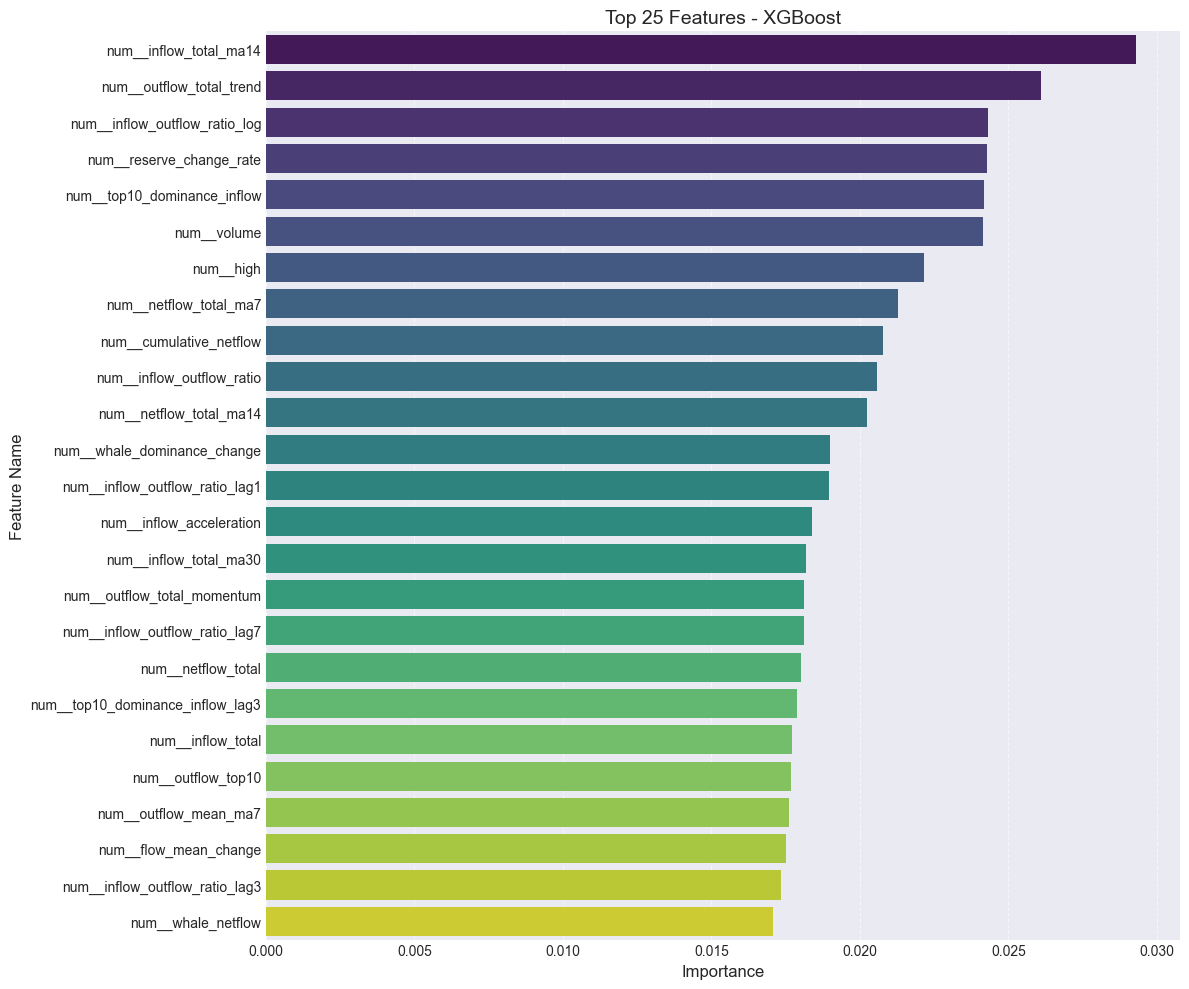


Plotting Random Forest Feature Importance...

--- Plotting Feature Importance for Random Forest ---
Feature importance plot saved to bitcoin_onchain_models/feature_importance_Random_Forest.png


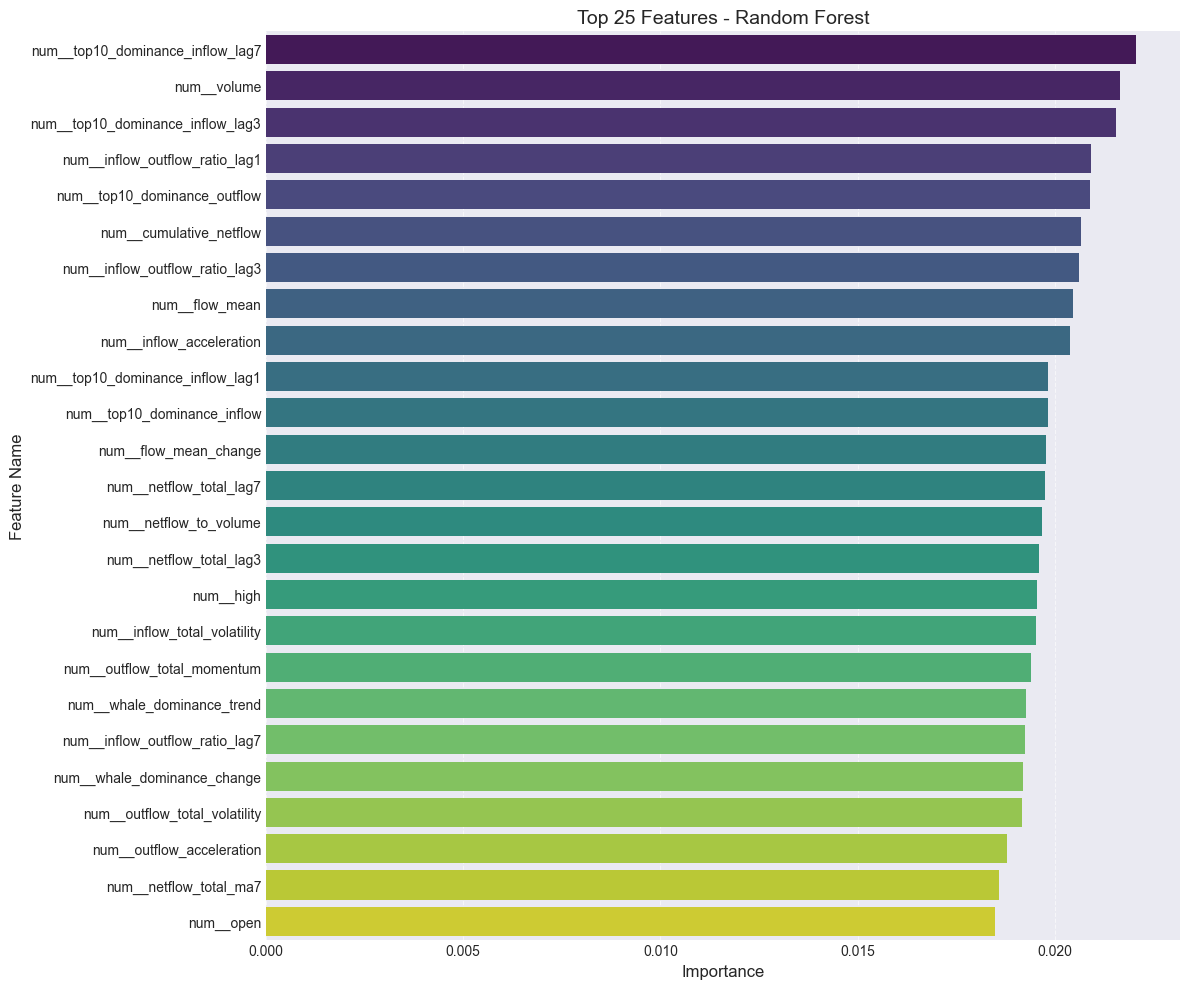


Plotting Logistic (Abs Coeff) Feature Importance...

--- Plotting Feature Importance for Logistic (Abs Coeff) ---
Feature importance plot saved to bitcoin_onchain_models/feature_importance_Logistic__Abs_Coeff.png


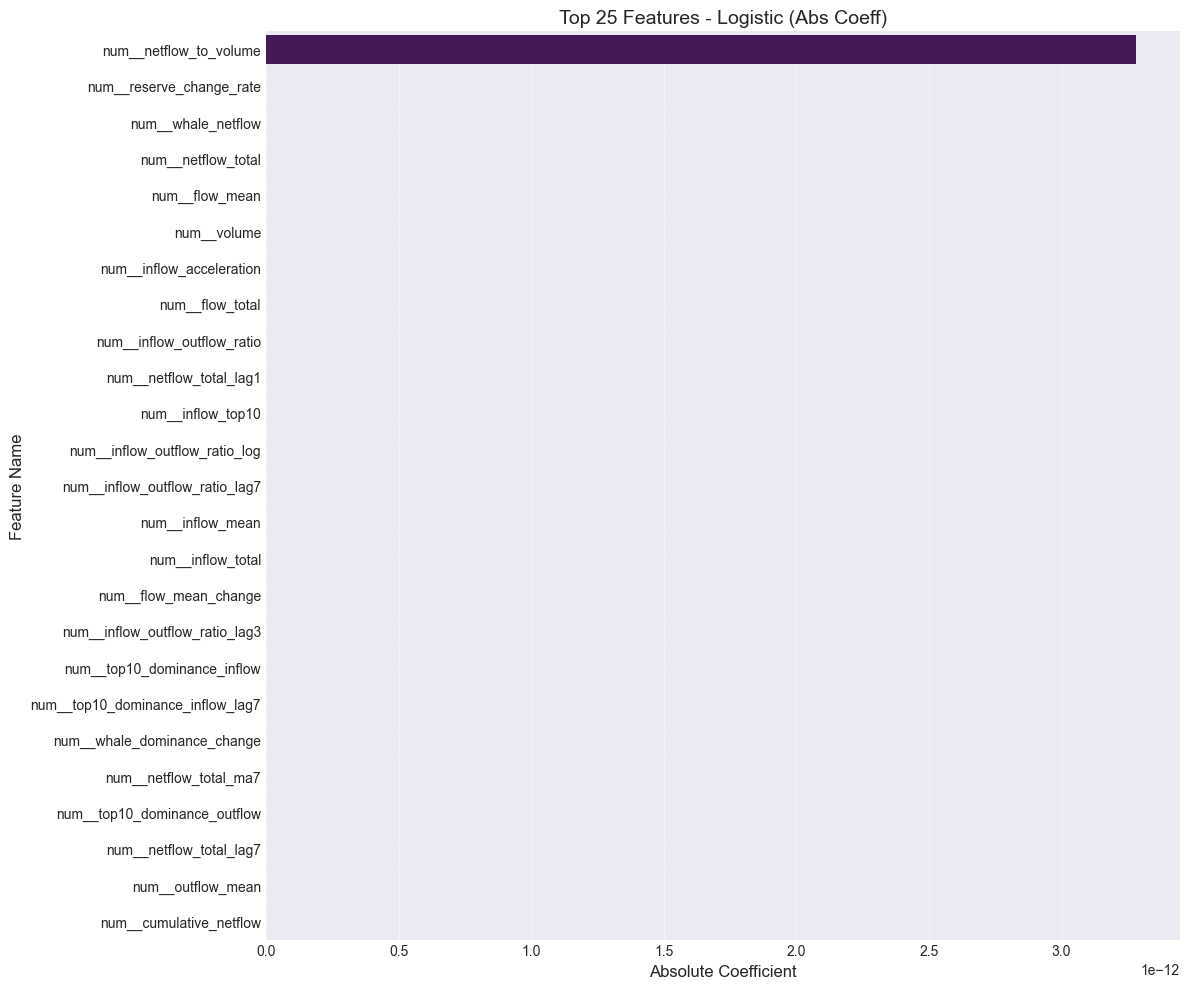


Generated feature importance plots for: XGBoost, Random Forest, Logistic


In [109]:
# --- Step 9: Plotting Feature Importance ---
print("\n--- Step 9: Plotting Feature Importance ---") #

# Plot importance only if models dictionary and feature names list exist
if ('models' in locals() and models and
    'processed_feature_names' in locals() and
    processed_feature_names is not None): # Check models exists/populated and feature names exist

    # CORRECTION 3: Explicitly check if the feature names list/array is empty
    feature_names_is_empty = False
    try:
        # Use .size for numpy arrays, len() for lists
        if hasattr(processed_feature_names, 'size'): # Check if it has a 'size' attribute (like numpy array)
             if processed_feature_names.size == 0:
                  feature_names_is_empty = True
        elif isinstance(processed_feature_names, (list, tuple)): # Check if it's a list or tuple
             if len(processed_feature_names) == 0:
                  feature_names_is_empty = True
        # Add elif for other potential types if necessary

    except Exception as e_check:
         print(f"[DEBUG] Error checking if processed_feature_names is empty: {e_check}")
         # Assume it might be invalid if check fails, skip plotting
         feature_names_is_empty = True


    if feature_names_is_empty: # Check the flag
          print("Skipping feature importance plotting: 'processed_feature_names' is empty or invalid.")
    else:
        importance_plots_generated = [] # Track which plots were made

        # --- Plot for Models Supporting Importance ---
        # Iterate through the models dictionary
        for model_name, model_object in models.items(): #
            if model_object is not None: # Check if model was trained successfully
                 supported = False # Flag to check if importance can be plotted
                 importance_label = f"{model_name}" # Base label for the plot
                 # Check for tree-based importance or linear coefficients
                 if hasattr(model_object, 'feature_importances_') or \
                    (hasattr(model_object, 'coef_') and 'Logistic' in model_name) or \
                    (hasattr(model_object, 'named_steps') and any(hasattr(step, 'feature_importances_') or hasattr(step, 'coef_') for step in model_object.named_steps.values())): # Check model or pipeline steps
                      supported = True #
                      # Adjust label if using coefficients for Logistic Regression
                      if 'Logistic' in model_name and not hasattr(model_object, 'feature_importances_'): # Check direct attribute first
                           is_pipeline_logistic = False
                           if hasattr(model_object, 'named_steps'):
                               for step_name in ['logreg', 'logisticregression']:
                                   if step_name in model_object.named_steps and hasattr(model_object.named_steps[step_name], 'coef_'):
                                       is_pipeline_logistic = True
                                       break
                           if hasattr(model_object, 'coef_') or is_pipeline_logistic:
                                importance_label += " (Abs Coeff)" #


                 if supported: #
                     try:
                         print(f"\nPlotting {importance_label} Feature Importance...") #
                         # Ensure processed_feature_names is passed correctly
                         importance_df = plot_feature_importance(
                             model_object, # Pass the model object or pipeline
                             processed_feature_names, # Pass the feature names list/array
                             model_name=importance_label, # Use descriptive name
                             top_n=25 # Show top N features
                         ) #
                         if importance_df is not None: importance_plots_generated.append(model_name) # Track success
                     except Exception as e: #
                         print(f"Could not plot importance for {model_name}: {e}") #
                 # else: # Optional: Log unsupported models
                     # print(f"Skipping importance plot for {model_name}: Not a standard supported type.")

        # --- Summary ---
        if not importance_plots_generated: #
            print("No feature importance plots were generated (models might be missing, failed, or unsupported).") #
        else: #
            print(f"\nGenerated feature importance plots for: {', '.join(importance_plots_generated)}") #

else: #
     # Explain why plotting is skipped
     reason = []
     if 'models' not in locals() or not models: reason.append("'models' dictionary is missing or empty")
     if 'processed_feature_names' not in locals(): reason.append("'processed_feature_names' variable is missing")
     elif processed_feature_names is None: reason.append("'processed_feature_names' is None")
     # No longer include the ambiguous check reason
     print(f"Skipping feature importance plotting because: {', '.join(reason)}.") #

In [110]:
# --- Step 10: Running Backtest on Test Set ---
# NOTE: Step 10a (Parameter Tuning) has been removed.
# This step uses the fixed BACKTESTING_PARAMS defined earlier.
print("\n--- Step 10: Running Final Backtest on Test Set ---") #

backtest = None # Initialize
backtest_results_df = None # Initialize

# Ensure we have the necessary components for the TEST set backtest
# Use test_ensemble_pred (or a fallback if ensemble failed but single model preds exist)
predictions_for_backtest = test_ensemble_pred
if predictions_for_backtest is None:
     print("Error: No predictions available for the test set. Cannot run backtest.")
     # Optional: Add fallback logic here if needed, e.g., use neutral predictions
     # predictions_for_backtest = pd.Series(0.5, index=X_test.index) # Example: Neutral prediction fallback
else:
     # Check if other necessary data exists
     if X_test is not None and not X_test.empty and df_ready is not None:
         try:
             # Prepare the TEST data slice - Ensure it has the PRICE_COLUMN and any other columns needed by strategy logic
             if not isinstance(X_test.index, pd.DatetimeIndex):
                  raise ValueError("X_test index must be DatetimeIndex for backtesting.")

             # Select the relevant slice from df_ready using the test set index
             test_data_for_backtest = df_ready.loc[X_test.index].copy() #

             # Ensure predictions are a pandas Series with the same index as test_data_for_backtest
             if not isinstance(predictions_for_backtest, pd.Series):
                  if len(predictions_for_backtest) == len(test_data_for_backtest.index):
                      test_predictions_series = pd.Series(predictions_for_backtest, index=test_data_for_backtest.index) #
                  else:
                       raise ValueError("Length mismatch between predictions and test data index.")
             else:
                  # Reindex predictions if necessary (should already match if predict_ensemble worked correctly)
                  test_predictions_series = predictions_for_backtest.reindex(test_data_for_backtest.index, fill_value=0.5) # Fill missing with neutral

             # Verify necessary columns exist in the slice
             required_cols_backtest = [PRICE_COLUMN] # Add other columns if needed by strategy/helpers
             missing_cols = [col for col in required_cols_backtest if col not in test_data_for_backtest.columns]
             if missing_cols:
                  raise ValueError(f"Missing required columns for backtest in test_data_for_backtest: {missing_cols}")


             print(f"\nRunning FINAL backtest on {len(test_data_for_backtest)} test samples...") #
             print("Using fixed parameters and test set predictions.") #
             print("Backtesting Parameters Used:")
             for key, value in BACKTESTING_PARAMS.items():
                  print(f"- {key}: {value}")

             # Instantiate and run the backtest strategy using the fixed BACKTESTING_PARAMS
             backtest = OnChainBitcoinStrategy(
                 df=test_data_for_backtest, # Pass the data slice for the test period
                 predictions=test_predictions_series, # Pass predictions aligned to test data
                 params=BACKTESTING_PARAMS.copy(), # Use the fixed global parameters
                 price_col=PRICE_COLUMN # Specify the price column
             ) #

             if backtest.results is not None and not backtest.results.empty: #
                 backtest_results_df = backtest.results # Store the results df
                 print("\nFinal backtest simulation complete.") #
                 print("Sample of final backtest results DataFrame (first 5 rows):") #
                 print(backtest_results_df.head()) #
             else: #
                 print("\nFinal backtest failed to produce results.") #
                 backtest_results_df = None # Ensure it's None

         except Exception as e: #
             print(f"FATAL ERROR occurred during the final backtesting run: {e}") #
             traceback.print_exc() #
             backtest = None # Ensure backtest object is None if it failed
             backtest_results_df = None
     else: #
         print("Skipping final backtest run: Missing test set data (X_test) or original data (df_ready).") #

# Final check if backtest object exists
if backtest is None:
     print("\nBacktest object was not successfully created. Evaluation and plotting will be skipped.")


--- Step 10: Running Final Backtest on Test Set ---

Running FINAL backtest on 8645 test samples...
Using fixed parameters and test set predictions.
Backtesting Parameters Used:
- INITIAL_CASH: 10000
- COMMISSION_PERC: 0.0006
- BASE_POSITION_SIZE: 0.1
[DEBUG] OnChainBitcoinStrategy.__init__ called (Buy, Hold, Sell Mode).
[DEBUG] Initializing strategy simulation (_run_strategy - Buy, Hold, Sell)...
[DEBUG] _run_strategy (Buy, Hold, Sell Mode) starting...
[DEBUG] Starting buy, hold, sell backtest loop for 8645 steps...
[DEBUG] Hold position at 2024-03-19 20:00:00 - Price: 64963.00, Pred: 0.463, BTC Held: 0.000000
[DEBUG] Hold position at 2024-03-19 21:00:00 - Price: 64843.00, Pred: 0.492, BTC Held: 0.000000
[DEBUG] Hold position at 2024-03-19 23:00:00 - Price: 64395.00, Pred: 0.467, BTC Held: 0.000000
[DEBUG] Hold position at 2024-03-20 00:00:00 - Price: 63755.00, Pred: 0.516, BTC Held: 0.000000
[DEBUG] Hold position at 2024-03-20 01:00:00 - Price: 63954.00, Pred: 0.485, BTC Held: 0.000

In [111]:
# --- Step 10b: Running Backtest on Validation Set ---
# This step uses the fixed BACKTESTING_PARAMS defined earlier, similar to the test set run.
print("\n--- Step 10b: Running Backtest on Validation Set ---") #

val_backtest = None # Initialize for validation backtest
val_backtest_results_df = None # Initialize for validation backtest results

# Ensure we have the necessary components for the VALIDATION set backtest
# Use val_ensemble_pred
predictions_for_val_backtest = val_ensemble_pred
if predictions_for_val_backtest is None:
    print("Error: No predictions available for the validation set. Cannot run backtest.")
    # Optional: Add fallback logic here if needed
else:
    # Check if other necessary data exists
    if X_val is not None and not X_val.empty and df_ready is not None:
        try:
            # Prepare the VALIDATION data slice
            if not isinstance(X_val.index, pd.DatetimeIndex):
                raise ValueError("X_val index must be DatetimeIndex for backtesting.")

            # Select the relevant slice from df_ready using the validation set index
            val_data_for_backtest = df_ready.loc[X_val.index].copy() #

            # Ensure predictions are a pandas Series with the same index as val_data_for_backtest
            if not isinstance(predictions_for_val_backtest, pd.Series):
                if len(predictions_for_val_backtest) == len(val_data_for_backtest.index):
                    val_predictions_series = pd.Series(predictions_for_val_backtest, index=val_data_for_backtest.index) #
                else:
                    raise ValueError("Length mismatch between validation predictions and validation data index.")
            else:
                # Reindex predictions if necessary
                val_predictions_series = predictions_for_val_backtest.reindex(val_data_for_backtest.index, fill_value=0.5) # Fill missing with neutral

            # Verify necessary columns exist in the slice
            required_cols_backtest = [PRICE_COLUMN] # Add other columns if needed
            missing_cols = [col for col in required_cols_backtest if col not in val_data_for_backtest.columns]
            if missing_cols:
                raise ValueError(f"Missing required columns for backtest in val_data_for_backtest: {missing_cols}")


            print(f"\nRunning validation backtest on {len(val_data_for_backtest)} validation samples...") #
            print("Using fixed parameters and validation set predictions.") #
            print("Backtesting Parameters Used:")
            for key, value in BACKTESTING_PARAMS.items():
                print(f"- {key}: {value}")

            # Instantiate and run the backtest strategy using the fixed BACKTESTING_PARAMS
            # Using the same OnChainBitcoinStrategy class as the test set example
            val_backtest = OnChainBitcoinStrategy(
                df=val_data_for_backtest,         # Pass the data slice for the validation period
                predictions=val_predictions_series, # Pass predictions aligned to validation data
                params=BACKTESTING_PARAMS.copy(), # Use the fixed global parameters
                price_col=PRICE_COLUMN          # Specify the price column
            ) #

            if val_backtest.results is not None and not val_backtest.results.empty: #
                val_backtest_results_df = val_backtest.results # Store the validation results df
                print("\nValidation backtest simulation complete.") #
                print("Sample of validation backtest results DataFrame (first 5 rows):") #
                print(val_backtest_results_df.head()) #
            else: #
                print("\nValidation backtest failed to produce results.") #
                val_backtest_results_df = None # Ensure it's None

        except Exception as e: #
            print(f"ERROR occurred during the validation backtesting run: {e}") #
            traceback.print_exc() #
            val_backtest = None # Ensure val_backtest object is None if it failed
            val_backtest_results_df = None
    else: #
        print("Skipping validation backtest run: Missing validation set data (X_val) or original data (df_ready).") #

# Final check if val_backtest object exists
if val_backtest is None:
    print("\nValidation Backtest object was not successfully created. Evaluation and plotting for validation might be skipped.")


--- Step 10b: Running Backtest on Validation Set ---

Running validation backtest on 6484 validation samples...
Using fixed parameters and validation set predictions.
Backtesting Parameters Used:
- INITIAL_CASH: 10000
- COMMISSION_PERC: 0.0006
- BASE_POSITION_SIZE: 0.1
[DEBUG] OnChainBitcoinStrategy.__init__ called (Buy, Hold, Sell Mode).
[DEBUG] Initializing strategy simulation (_run_strategy - Buy, Hold, Sell)...
[DEBUG] _run_strategy (Buy, Hold, Sell Mode) starting...
[DEBUG] Starting buy, hold, sell backtest loop for 6484 steps...
[DEBUG] Hold position at 2023-06-23 16:00:00 - Price: 30110.00, Pred: 0.509, BTC Held: 0.000000
[DEBUG] Hold position at 2023-06-23 17:00:00 - Price: 30088.00, Pred: 0.501, BTC Held: 0.000000
[DEBUG] Hold position at 2023-06-23 18:00:00 - Price: 30291.00, Pred: 0.505, BTC Held: 0.000000
[DEBUG] Hold position at 2023-06-23 19:00:00 - Price: 31243.00, Pred: 0.530, BTC Held: 0.000000
[DEBUG] Hold position at 2023-06-23 20:00:00 - Price: 31109.00, Pred: 0.52

In [112]:
# --- Step 11: Evaluating Backtest Performance ---
print("\n--- Step 11: Evaluating Backtest Performance ---") #

if backtest is not None and backtest.results is not None and not backtest.results.empty: #
    try:
        # Calculate metrics using the method within the backtest object
        backtest_metrics = backtest.calculate_metrics() #

        print("\nBacktest Performance Metrics (Test Set):") #
        print("-" * 40)
        # Use .get() with default 0 for safety, format nicely
        print(f"- Initial Cash:        ${backtest.params.get('INITIAL_CASH', 0):,.2f}") #
        final_value = backtest.results['portfolio_value'].iloc[-1] #
        print(f"- Final Portfolio Value: ${final_value:,.2f}") #
        print(f"- Total Return:        {backtest_metrics.get('total_return', 0):.2%}") #
        print(f"- Annual Return:       {backtest_metrics.get('annual_return', 0):.2%}") #
        print(f"- Sharpe Ratio:        {backtest_metrics.get('sharpe', 0):.3f}") #
        print(f"- Max Drawdown:        {backtest_metrics.get('max_drawdown', 0):.2%}") #
        print(f"- Win Rate:            {backtest_metrics.get('win_rate', 0):.2%}") #
        print(f"- Total Trades:        {backtest_metrics.get('total_trades', 0)}") #
        print(f"- Profit Factor:       {backtest_metrics.get('profit_factor', 0):.2f}") #
        print(f"- System Quality (SQN):{backtest_metrics.get('sqn', 0):.2f}") #
        print("-" * 40)

        # --- Save metrics to a CSV file ---
        metrics_df = pd.DataFrame([backtest_metrics]) # Create DataFrame from metrics dict
        metrics_filename = os.path.join(MODEL_OUTPUT_DIR, 'backtest_metrics.csv') #
        os.makedirs(os.path.dirname(metrics_filename) or '.', exist_ok=True) # Ensure directory exists
        try:
            metrics_df.to_csv(metrics_filename, index=False) #
            print(f"\nBacktest metrics saved to: {metrics_filename}") #
        except Exception as e_save:
             print(f"Error saving backtest metrics to CSV: {e_save}")


    except Exception as e: #
        print(f"An error occurred during backtest evaluation: {e}") #
        traceback.print_exc() #
else: #
    print("Skipping backtest evaluation: Backtest object or results are not available.") #


--- Step 11: Evaluating Backtest Performance ---

Backtest Performance Metrics (Test Set):
----------------------------------------
- Initial Cash:        $10,000.00
- Final Portfolio Value: $14,839.31
- Total Return:        48.39%
- Annual Return:       49.04%
- Sharpe Ratio:        0.762
- Max Drawdown:        -23.51%
- Win Rate:            35.43%
- Total Trades:        2029
- Profit Factor:       1.03
- System Quality (SQN):0.76
----------------------------------------

Backtest metrics saved to: bitcoin_onchain_models/backtest_metrics.csv


In [113]:
# --- Step 11b: Evaluating Validation Backtest Performance ---
print("\n--- Step 11b: Evaluating Validation Backtest Performance ---") #

# Check if the validation backtest ran successfully and produced results
if val_backtest is not None and val_backtest.results is not None and not val_backtest.results.empty: #
    try:
        # Calculate metrics using the method within the validation backtest object
        val_backtest_metrics = val_backtest.calculate_metrics() #

        print("\nBacktest Performance Metrics (Validation Set):") #
        print("-" * 40)
        # Use .get() with default 0 for safety, format nicely
        print(f"- Initial Cash:        ${val_backtest.params.get('INITIAL_CASH', 0):,.2f}") #
        val_final_value = val_backtest.results['portfolio_value'].iloc[-1] #
        print(f"- Final Portfolio Value: ${val_final_value:,.2f}") #
        print(f"- Total Return:        {val_backtest_metrics.get('total_return', 0):.2%}") #
        print(f"- Annual Return:       {val_backtest_metrics.get('annual_return', 0):.2%}") #
        print(f"- Sharpe Ratio:        {val_backtest_metrics.get('sharpe', 0):.3f}") #
        print(f"- Max Drawdown:        {val_backtest_metrics.get('max_drawdown', 0):.2%}") #
        print(f"- Win Rate:            {val_backtest_metrics.get('win_rate', 0):.2%}") #
        print(f"- Total Trades:        {val_backtest_metrics.get('total_trades', 0)}") #
        print(f"- Profit Factor:       {val_backtest_metrics.get('profit_factor', 0):.2f}") #
        print(f"- System Quality (SQN):{val_backtest_metrics.get('sqn', 0):.2f}") #
        print("-" * 40)

        # --- Save validation metrics to a separate CSV file ---
        val_metrics_df = pd.DataFrame([val_backtest_metrics]) # Create DataFrame from validation metrics dict
        val_metrics_filename = os.path.join(MODEL_OUTPUT_DIR, 'validation_backtest_metrics.csv') # Distinct filename
        os.makedirs(os.path.dirname(val_metrics_filename) or '.', exist_ok=True) # Ensure directory exists
        try:
            val_metrics_df.to_csv(val_metrics_filename, index=False) #
            print(f"\nValidation backtest metrics saved to: {val_metrics_filename}") #
        except Exception as e_save:
            print(f"Error saving validation backtest metrics to CSV: {e_save}")


    except Exception as e: #
        print(f"An error occurred during validation backtest evaluation: {e}") #
        traceback.print_exc() #
else: #
    print("Skipping validation backtest evaluation: Validation backtest object or results are not available.") #


--- Step 11b: Evaluating Validation Backtest Performance ---

Backtest Performance Metrics (Validation Set):
----------------------------------------
- Initial Cash:        $10,000.00
- Final Portfolio Value: $15,306.81
- Total Return:        53.07%
- Annual Return:       71.70%
- Sharpe Ratio:        2.523
- Max Drawdown:        -13.83%
- Win Rate:            50.85%
- Total Trades:        662
- Profit Factor:       1.09
- System Quality (SQN):2.17
----------------------------------------

Validation backtest metrics saved to: bitcoin_onchain_models/validation_backtest_metrics.csv



--- Step 12: Plotting Backtest Results ---
Generating backtest plots...
Buy, hold, sell backtest results plot saved to bitcoin_onchain_models/buy_hold_sell_results.png


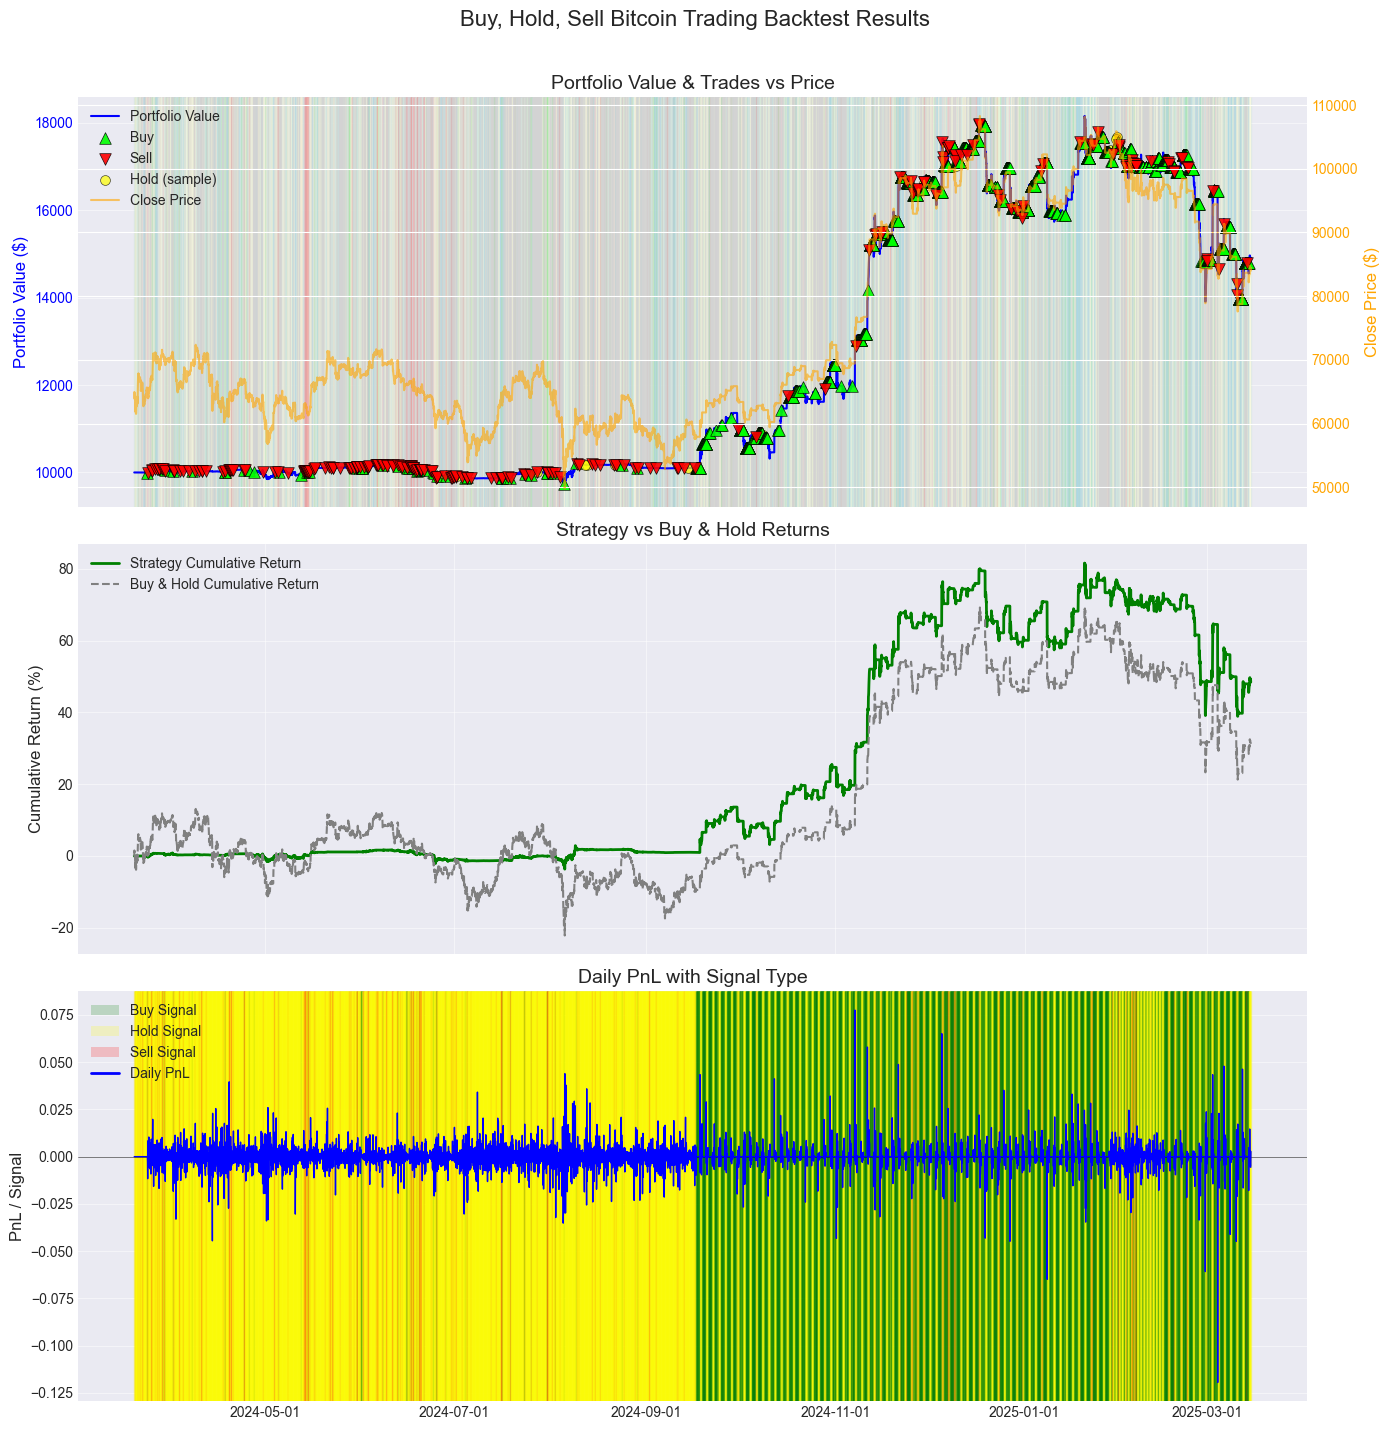

An error occurred during backtest plotting: 'OnChainBitcoinStrategy' object has no attribute '_plot_signal_distribution'


Traceback (most recent call last):
  File "C:\Users\User\AppData\Local\Temp\ipykernel_17104\1308197373.py", line 10, in <module>
    backtest.plot_results() #
    ^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\User\AppData\Local\Temp\ipykernel_17104\2673945181.py", line 593, in plot_results
    self._plot_signal_distribution()
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'OnChainBitcoinStrategy' object has no attribute '_plot_signal_distribution'


In [114]:
# --- Step 12: Plotting Backtest Results ---
print("\n--- Step 12: Plotting Backtest Results ---") #

if backtest is not None: # Check if backtest object was successfully created
    try:
        # Call the plotting methods of the strategy instance
        # This will generate plots for portfolio value and cumulative return,
        # and also call _plot_trade_analysis internally if trade history exists.
        print("Generating backtest plots...") #
        backtest.plot_results() #

        print("Backtest plots generated and potentially saved.") #

    except Exception as e: #
        print(f"An error occurred during backtest plotting: {e}") #
        traceback.print_exc() #
else: #
    print("Skipping backtest plotting: Backtest object is not available.") #


--- Step 12b: Plotting Validation Backtest Results ---
Generating validation backtest plots...
Buy, hold, sell backtest results plot saved to bitcoin_onchain_models/buy_hold_sell_results.png


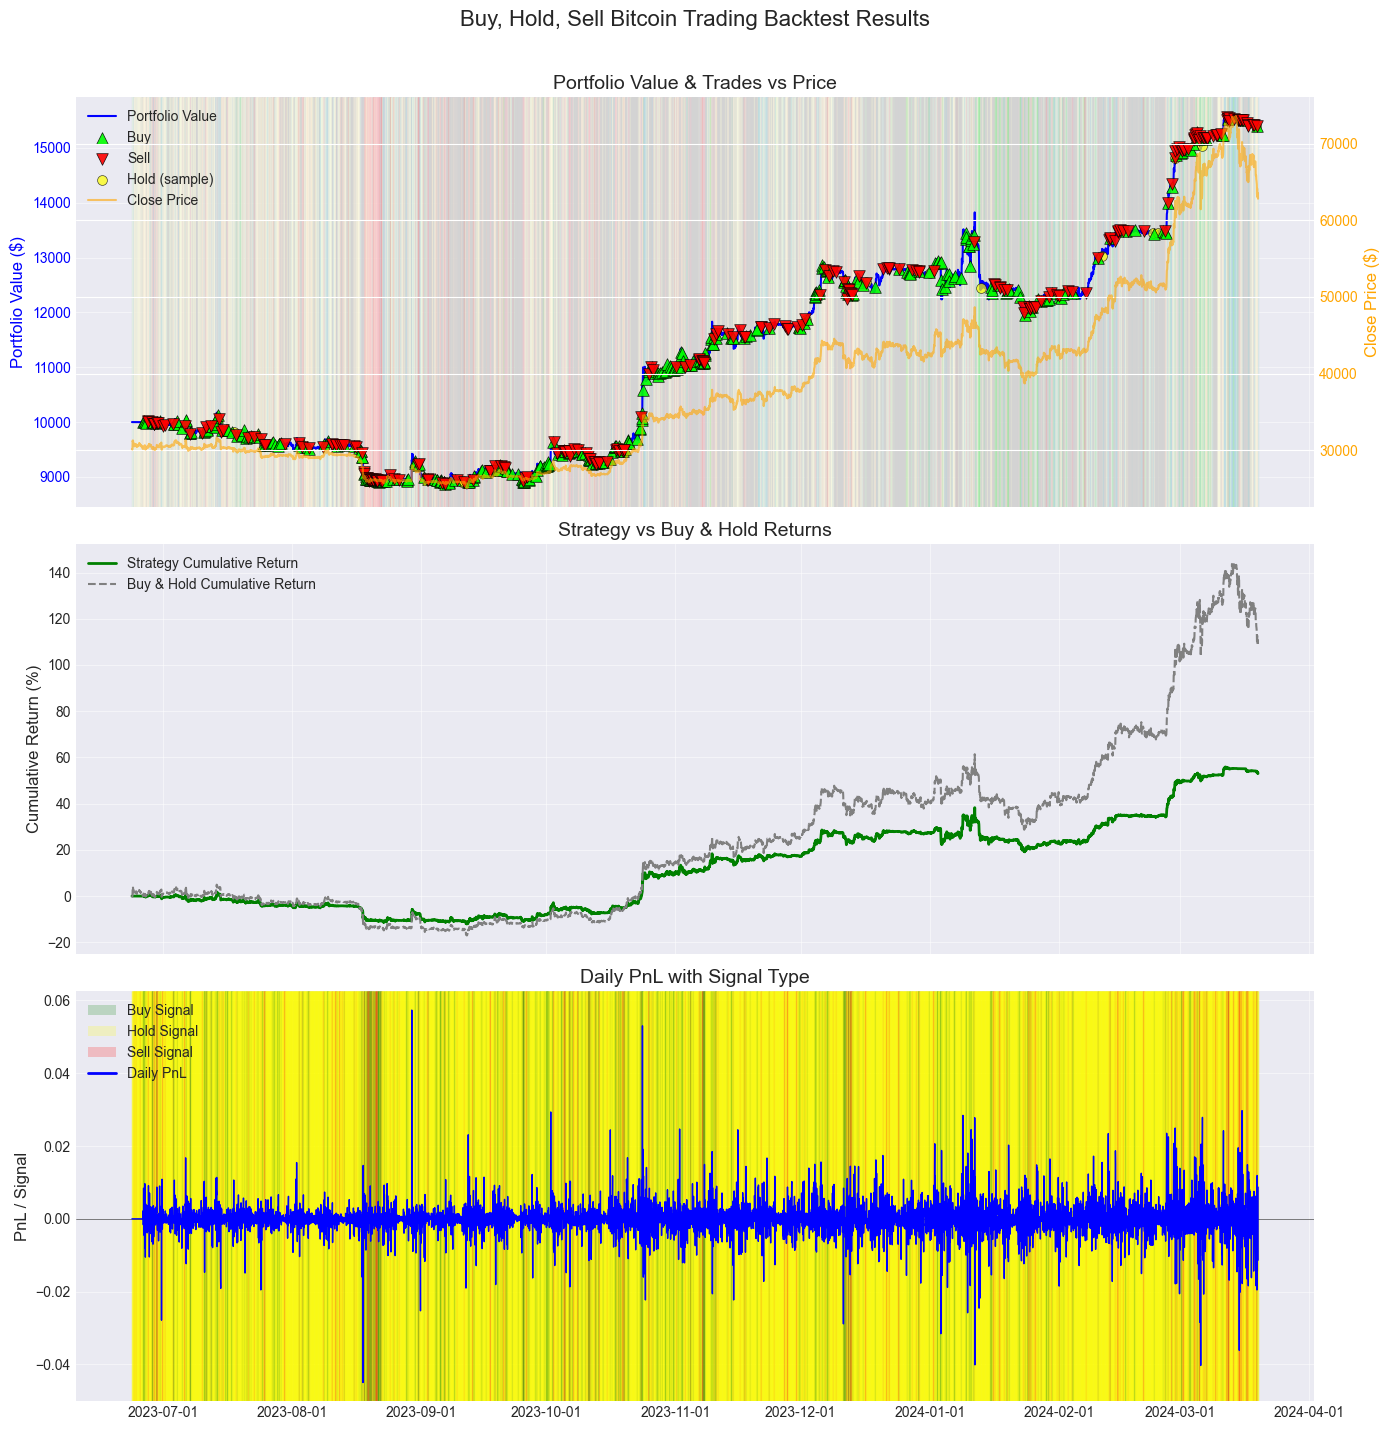

An error occurred during validation backtest plotting: 'OnChainBitcoinStrategy' object has no attribute '_plot_signal_distribution'


Traceback (most recent call last):
  File "C:\Users\User\AppData\Local\Temp\ipykernel_17104\1281620876.py", line 8, in <module>
    val_backtest.plot_results() # Call plot_results on the validation backtest object
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\User\AppData\Local\Temp\ipykernel_17104\2673945181.py", line 593, in plot_results
    self._plot_signal_distribution()
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'OnChainBitcoinStrategy' object has no attribute '_plot_signal_distribution'


In [115]:
# --- Step 12b: Plotting Validation Backtest Results ---
print("\n--- Step 12b: Plotting Validation Backtest Results ---") #

if val_backtest is not None: # Check if validation backtest object was successfully created
    try:
        # Call the plotting methods of the validation strategy instance
        print("Generating validation backtest plots...") #
        val_backtest.plot_results() # Call plot_results on the validation backtest object

        print("Validation backtest plots generated and potentially saved.") #

    except Exception as e: #
        print(f"An error occurred during validation backtest plotting: {e}") #
        traceback.print_exc() #
else: #
    print("Skipping validation backtest plotting: Validation Backtest object is not available.") #

In [116]:
# --- Step 13: Saving Models and Components ---
print("\n--- Step 13: Saving Models and Components ---") #

# Ensure the output directory exists
os.makedirs(MODEL_OUTPUT_DIR, exist_ok=True) #
print(f"Attempting to save components to: {os.path.abspath(MODEL_OUTPUT_DIR)}") # Use absolute path for clarity

saved_items_count = 0 # Counter for saved items

try:
    # --- Save trained models ---
    if 'models' in locals() and models: # Check if models dict exists
        print("Saving trained models...")
        for name, model in models.items(): #
            if model is not None: # Only save successfully trained models
                try:
                    model_path = os.path.join(MODEL_OUTPUT_DIR, f'{name}_model.joblib') #
                    joblib.dump(model, model_path) #
                    print(f"- Saved model: {name} to {model_path}") #
                    saved_items_count += 1
                except Exception as e_model: #
                    print(f"Error saving model '{name}': {e_model}") #
            # else: # Optional: Log skipped models
                # print(f"- Skipping model: {name} (was None)")
    else: #
        print("- No 'models' dictionary found to save.") #

    # --- Save the preprocessor ---
    if 'preprocessor' in locals() and preprocessor: # Check if preprocessor exists
        print("Saving preprocessor...")
        try:
            preprocessor_path = os.path.join(MODEL_OUTPUT_DIR, 'preprocessor.joblib') #
            joblib.dump(preprocessor, preprocessor_path) #
            print(f"- Saved preprocessor to {preprocessor_path}") #
            saved_items_count += 1
        except Exception as e_prep: #
             print(f"Error saving preprocessor: {e_prep}") #
    else: #
         print("- Preprocessor not found or not created, skipping save.") #

    # --- Save the list of feature columns used after preprocessing ---
    if 'processed_feature_names' in locals() and processed_feature_names: # Check if list exists
        print("Saving processed feature names...")
        try:
            features_path = os.path.join(MODEL_OUTPUT_DIR, 'feature_cols.joblib') #
            joblib.dump(processed_feature_names, features_path) #
            print(f"- Saved processed feature list ({len(processed_feature_names)} features) to {features_path}") #
            saved_items_count += 1
        except Exception as e_feat: #
             print(f"Error saving feature list: {e_feat}") #
    else: #
         print("- Processed feature names list not found, skipping save.") #

    # --- Save the ensemble weights ---
    if 'ensemble_weights' in locals() and ensemble_weights: # Check if weights exist
        print("Saving ensemble weights...")
        try:
            weights_path = os.path.join(MODEL_OUTPUT_DIR, 'ensemble_weights.joblib') #
            joblib.dump(ensemble_weights, weights_path) #
            print(f"- Saved ensemble weights to {weights_path}") #
            saved_items_count += 1
        except Exception as e_weights: #
            print(f"Error saving ensemble weights: {e_weights}") #
    else: #
        print("- Ensemble weights not found or not calculated, skipping save.") #

    print(f"\nSaving process complete. Items saved: {saved_items_count}") #

except Exception as e: # Catch any unexpected error during the overall saving process
     print(f"A critical error occurred during the saving process: {e}") #
     traceback.print_exc() #


--- Step 13: Saving Models and Components ---
Attempting to save components to: c:\Users\User\Downloads\bitcoin_onchain_models
Saving trained models...
- Saved model: XGBoost to bitcoin_onchain_models/XGBoost_model.joblib
- Saved model: Random Forest to bitcoin_onchain_models/Random Forest_model.joblib
- Saved model: MLP to bitcoin_onchain_models/MLP_model.joblib
- Saved model: Logistic to bitcoin_onchain_models/Logistic_model.joblib
Saving preprocessor...
- Saved preprocessor to bitcoin_onchain_models/preprocessor.joblib
A critical error occurred during the saving process: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


Traceback (most recent call last):
  File "C:\Users\User\AppData\Local\Temp\ipykernel_17104\1975929317.py", line 42, in <module>
    if 'processed_feature_names' in locals() and processed_feature_names: # Check if list exists
                                                 ^^^^^^^^^^^^^^^^^^^^^^^
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import traceback

# Add this method to your OnChainBitcoinStrategy class
def print_detailed_metrics(self, sample_size=None):
    """
    Print detailed metrics for analysis including price changes, PnL, equity, drawdown.
    
    Args:
        sample_size: Optional; if provided, only show this many rows (evenly sampled)
    """
    if not hasattr(self, 'results') or self.results is None or self.results.empty:
        print("No results available to display.")
        return pd.DataFrame()
    
    results = self.results
    
    # Calculate additional metrics if not already present
    if self.price_col in results.columns:
        if 'price_change' not in results.columns:
            results['price_change'] = results[self.price_col].pct_change().fillna(0) * 100
    
    # Calculate proper drawdown as current_equity - max_equity_so_far
    if 'portfolio_value' in results.columns:
        if 'drawdown_pct' not in results.columns:
            running_max = results['portfolio_value'].cummax()
            results['drawdown_pct'] = ((results['portfolio_value'] - running_max) / running_max) * 100
    
    # Determine which columns to include
    available_columns = results.columns.tolist()
    desired_columns = [
        'price_change', 'pnl', 'portfolio_value', 'drawdown_pct', 
        'position', 'position_signal', 'trade', 'signal', 'cash', 'btc_held'
    ]
    # Only include columns that actually exist
    columns_to_use = [col for col in desired_columns if col in available_columns]
    
    # Create a metrics DataFrame with selected columns
    metrics_df = results[columns_to_use].copy()
    
    # Optionally sample rows if requested
    if sample_size and sample_size < len(metrics_df):
        # Get evenly spaced indices
        indices = np.linspace(0, len(metrics_df)-1, sample_size, dtype=int)
        sampled_df = metrics_df.iloc[indices]
        print(f"Displaying {sample_size} sampled rows from {len(metrics_df)} total rows")
        display_df = sampled_df
    else:
        display_df = metrics_df
    
    # Print general statistics
    print("\n=== Strategy Metrics Summary ===")
    print(f"Total Rows: {len(results)}")
    
    if 'trade' in results.columns:
        print(f"Buy Trades: {(results['trade'] == 1).sum()}")
        print(f"Sell Trades: {(results['trade'] == -1).sum()}")
        print(f"Total Trades: {(results['trade'] != 0).sum()}")
    
    if 'position' in results.columns:
        print(f"Days with Position: {(results['position'] > 0).sum()}")
    
    if 'drawdown_pct' in results.columns:
        print(f"Max Drawdown: {results['drawdown_pct'].min():.2f}%")
    
    if 'portfolio_value' in results.columns:
        print(f"Final Equity: ${results['portfolio_value'].iloc[-1]:.2f}")
        initial_value = getattr(self, 'params', {}).get('INITIAL_CASH', results['portfolio_value'].iloc[0])
        if initial_value > 0:
            total_return = ((results['portfolio_value'].iloc[-1] / initial_value) - 1) * 100
            print(f"Total Return: {total_return:.2f}%")
    
    # Print the detailed metrics DataFrame
    print("\n=== Detailed Metrics ===")
    pd.set_option('display.float_format', '{:.4f}'.format)
    display_df = display_df.reset_index()  # Convert index to column
    return display_df

# Standalone function that works with any strategy class
def analyze_strategy_results(strategy):
    """
    Analyze the results of any strategy class that has a results DataFrame
    """
    # Check if the strategy has required attributes
    if not hasattr(strategy, 'results') or strategy.results is None or strategy.results.empty:
        print("No results available for analysis.")
        return None
    
    results = strategy.results
    available_columns = results.columns.tolist()
    print(f"Available columns: {available_columns}")
    
    # Check if calculate_metrics exists and use it
    if hasattr(strategy, 'calculate_metrics') and callable(strategy.calculate_metrics):
        try:
            metrics = strategy.calculate_metrics()
            print("\n=== STRATEGY PERFORMANCE METRICS ===")
            for key, value in metrics.items():
                if key in ['total_return', 'annual_return', 'win_rate', 'max_drawdown']:
                    print(f"{key.replace('_', ' ').title():20}: {value * 100:.2f}%")
                else:
                    print(f"{key.replace('_', ' ').title():20}: {value:.4f}")
        except Exception as e:
            print(f"Error using calculate_metrics: {e}")
    
    # Check if print_detailed_metrics exists (add this before running)
    if hasattr(strategy, 'print_detailed_metrics') and callable(strategy.print_detailed_metrics):
        try:
            detailed_metrics = strategy.print_detailed_metrics(sample_size=20)
        except Exception as e:
            print(f"Error using print_detailed_metrics: {e}")
            detailed_metrics = None
    else:
        # Use the function we defined above but bound to the strategy instance
        # This is a bit hacky but allows us to use the method without adding it to the class
        detailed_metrics = print_detailed_metrics.__get__(strategy, type(strategy))(sample_size=None)
    
    # Calculate drawdown and find max drawdown date
    if 'portfolio_value' in results.columns:
        running_max = results['portfolio_value'].cummax()
        drawdown_pct = ((results['portfolio_value'] - running_max) / running_max) * 100
        max_dd_idx = drawdown_pct.idxmin()
        if not pd.isna(max_dd_idx):
            max_dd_date = results.index[max_dd_idx] if isinstance(max_dd_idx, (int, np.integer)) else max_dd_idx
            max_dd = drawdown_pct.min()
            print(f"\nMax Drawdown of {max_dd:.2f}% occurred on {max_dd_date}")
    
    return detailed_metrics

# === DIRECT USAGE EXAMPLE ===
# Replace 'strategy_instance' with your actual strategy instance name
analyze_strategy_results(backtest)
# Or: analyze_strategy_results(test_strategy)

Available columns: ['transactions_count_flow_1', 'current_regime', 'predicted_next_regime', 'next_regime_probability', 'start_time', 'inflow_mean', 'inflow_mean_ma7', 'inflow_top10', 'inflow_total', 'outflow_mean', 'outflow_mean_ma7', 'outflow_top10', 'outflow_total', 'netflow_total', 'transactions_count_flow_2', 'open', 'high', 'low', 'close', 'volume', 'flow_mean', 'flow_total', 'inflow_outflow_ratio', 'inflow_outflow_ratio_log', 'top10_dominance_inflow', 'top10_dominance_outflow', 'netflow_sign', 'netflow_to_volume', 'flow_mean_change', 'inflow_outflow_ratio_lag1', 'netflow_total_lag1', 'top10_dominance_inflow_lag1', 'inflow_outflow_ratio_lag3', 'netflow_total_lag3', 'top10_dominance_inflow_lag3', 'inflow_outflow_ratio_lag7', 'netflow_total_lag7', 'top10_dominance_inflow_lag7', 'inflow_acceleration', 'outflow_acceleration', 'inflow_total_ma7', 'outflow_total_ma7', 'netflow_total_ma7', 'inflow_total_ma14', 'outflow_total_ma14', 'netflow_total_ma14', 'inflow_total_ma30', 'outflow_tota

,datetime,price_change,pnl,portfolio_value,drawdown_pct,position,trade,signal,cash,btc_held
0,2024-03-19 19:00:00,0.0000,0.0000,10000.0000,0.0000,0.0000,0,0,10000.0000,0.0000
1,2024-03-19 20:00:00,1.5253,0.0000,10000.0000,0.0000,0.0000,0,0,10000.0000,0.0000
2,2024-03-19 21:00:00,-0.1847,-0.0000,10000.0000,0.0000,0.0000,0,0,10000.0000,0.0000
3,2024-03-19 22:00:00,-0.2190,-0.0000,10000.0000,0.0000,0.0000,0,-1,10000.0000,0.0000
4,2024-03-19 23:00:00,-0.4729,-0.0000,10000.0000,0.0000,0.0000,0,0,10000.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...
8640,2025-03-14 19:00:00,-0.0177,-0.0002,14931.7315,-17.7693,1.0000,0,0,1550.3961,0.1582
8641,2025-03-14 20:00:00,-0.4991,-0.0050,14864.9507,-18.1371,1.0000,0,0,1550.3961,0.1582
8642,2025-03-14 21:00:00,0.0808,0.0008,14875.7116,-18.0778,1.0000,0,0,1550.3961,0.1582
8643,2025-03-14 22:00:00,0.2898,0.0029,14914.3242,-17.8652,1.0000,0,0,1550.3961,0.1582


In [118]:
# --- Step 14: Exporting Key Results to CSV Files ---
print("\n--- Step 14: Exporting Key Results to CSV Files ---") #

export_files_count = 0 # Counter for exported files

# --- 1. Export Backtest Results DataFrame ---
if 'backtest_results_df' in locals() and isinstance(backtest_results_df, pd.DataFrame) and not backtest_results_df.empty: #
    print("Exporting backtest simulation results...")
    try:
        backtest_results_filename = os.path.join(MODEL_OUTPUT_DIR, 'backtest_simulation_results.csv') #
        # Save with index (which is the date)
        backtest_results_df.to_csv(backtest_results_filename, index=True) #
        print(f"- Successfully exported backtest simulation results to: {backtest_results_filename}") #
        export_files_count += 1
    except Exception as e: #
        print(f"Error exporting backtest simulation results: {e}") #
else: #
    print("- Skipping export of backtest simulation results (DataFrame not found or empty).") #

# --- 2. Export Trade History DataFrame ---
# Check if the backtest object exists and has the trade_history attribute
if 'backtest' in locals() and backtest is not None and hasattr(backtest, 'trade_history') and isinstance(backtest.trade_history, pd.DataFrame) and not backtest.trade_history.empty: #
    print("Exporting trade history...")
    try:
        trade_history_filename = os.path.join(MODEL_OUTPUT_DIR, 'backtest_trade_history.csv') #
        # Usually save trade history without the default integer index
        backtest.trade_history.to_csv(trade_history_filename, index=False) #
        print(f"- Successfully exported trade history to: {trade_history_filename}") #
        export_files_count += 1
    except Exception as e: #
        print(f"Error exporting trade history: {e}") #
else: #
    print("- Skipping export of trade history (backtest object or history not found/empty).") #

# --- 3. Export Model Evaluation Metrics ---
if 'all_metrics' in locals() and isinstance(all_metrics, dict) and all_metrics: #
    print("Exporting model evaluation metrics...")
    try:
        # Convert the dictionary of dictionaries to a list of dictionaries for DataFrame creation
        metrics_list_for_export = [] #
        for eval_key, metrics_dict in all_metrics.items(): #
            if isinstance(metrics_dict, dict): #
                # Create a flat dictionary including the evaluation key (e.g., 'Ensemble_Test')
                flat_metrics = {'evaluation_key': eval_key} # Add key identifying the evaluation
                flat_metrics.update(metrics_dict) # Add metrics from the inner dict

                # Optional: Further flatten the classification report dict if needed
                if 'classification_report_dict' in flat_metrics and isinstance(flat_metrics['classification_report_dict'], dict): #
                     try: # Flatten specific scores like F1 for class 1
                          class_1_report = flat_metrics['classification_report_dict'].get('Up (1)', {}) # Use target name 'Up (1)'
                          if isinstance(class_1_report, dict):
                               flat_metrics['precision_1'] = class_1_report.get('precision')
                               flat_metrics['recall_1'] = class_1_report.get('recall')
                               flat_metrics['f1_score_1'] = class_1_report.get('f1-score')
                               flat_metrics['support_1'] = class_1_report.get('support')
                          # Flatten overall scores
                          flat_metrics['accuracy_overall'] = flat_metrics['classification_report_dict'].get('accuracy')
                          if 'macro avg' in flat_metrics['classification_report_dict']:
                                flat_metrics['f1_macro_avg'] = flat_metrics['classification_report_dict']['macro avg'].get('f1-score')
                          if 'weighted avg' in flat_metrics['classification_report_dict']:
                                flat_metrics['f1_weighted_avg'] = flat_metrics['classification_report_dict']['weighted avg'].get('f1-score')
                     except Exception as e_flat:
                          print(f"Warning: Could not fully flatten classification report for {eval_key}: {e_flat}")
                     # Remove the nested dict after flattening relevant parts
                     flat_metrics.pop('classification_report_dict', None) # Remove original dict
                # Remove text report if dict was processed
                if 'classification_report_text' in flat_metrics:
                    flat_metrics.pop('classification_report_text', None) # Optionally remove text version

                metrics_list_for_export.append(flat_metrics) # Add flattened dict to list
            # else: # Optional: Log unexpected format
                 # print(f"Warning: Unexpected format for metrics key '{eval_key}'. Skipping export.")

        if metrics_list_for_export: # Only proceed if we have data to export
            metrics_export_df = pd.DataFrame(metrics_list_for_export) # Create DataFrame
            evaluation_metrics_filename = os.path.join(MODEL_OUTPUT_DIR, 'model_evaluation_metrics.csv') #
            metrics_export_df.to_csv(evaluation_metrics_filename, index=False) #
            print(f"- Successfully exported evaluation metrics to: {evaluation_metrics_filename}") #
            export_files_count += 1
        else: #
            print("- No suitable metrics data found to export.") #

    except Exception as e: #
        print(f"Error exporting evaluation metrics: {e}") #
        traceback.print_exc() # More detail for debugging metric export
else: #
    print("- Skipping export of evaluation metrics (dictionary 'all_metrics' not found or empty).") #


print(f"\nCSV export process complete. Files exported: {export_files_count}") #


--- Step 14: Exporting Key Results to CSV Files ---
Exporting backtest simulation results...
- Successfully exported backtest simulation results to: bitcoin_onchain_models/backtest_simulation_results.csv
Exporting trade history...
- Successfully exported trade history to: bitcoin_onchain_models/backtest_trade_history.csv
Exporting model evaluation metrics...
- Successfully exported evaluation metrics to: bitcoin_onchain_models/model_evaluation_metrics.csv

CSV export process complete. Files exported: 3
